In [151]:
%config Completer.use_jedi = False #para lograr el autocompletar


# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

from fnmatch import fnmatch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup as bs

#decia: from pattern import web --> Pattern no existe mas y era de Python2, pero web está en beautifulsoup, asique hice import de beautifulsoup, veré si anda

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
#rcParams['axes.edge_cycle'] = dark2_colors --> no anda
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'



#rcParams.keys()

# Introduction

This was the [XKCD comic](http://xkcd.com/1131/) after the 2012 Presidential election:

<img src="http://imgs.xkcd.com/comics/math.png">

The comic refers to the fact that Nate Silver's statistical model (which is based mostly on combining information from pre-election polls) correctly predicted the outcome of the 2012 presidential race in all 50 states. 

Polling data isn't a perfect predictor for the future, and some polls are more accurate than others. This means that election forecastors must consider prediction uncertainty when building models.

In this first assignment, you will perform a simple analysis of polling data about the upcoming <a href="http://en.wikipedia.org/wiki/Governor_(United_States)">Governor races</a>. The assignment has three main parts:

**First** you will build some tools to download historical polling data from the web, and parse it into a more convenient format. 

**Next** you will use these tools to aggregate and visualize several past Governor races

**Finally** you will run a bootstrap analysis to estimate the probable outcome of current Governor races, given the level of precision of historical polls.

---

# Part 1: Collect and Clean

The [Real Clear Politics](http://www.realclearpolitics.com) website archives many political polls. In addition, they combine related polls to form an "RCP average" estimate of public opinion over time. For example, the chart on [this page](http://www.realclearpolitics.com/epolls/2012/president/us/general_election_romney_vs_obama-1171.html) shows historical polling data for the Obama-Romney presidential race. The chart is an average of the polling data table below the chart.

The data used to generate plots like this are stored as XML pages, with URLs like:

http://charts.realclearpolitics.com/charts/[id].xml

Here, [id] is a unique integer, found at the end of the URL of the page that displays the graph. The id for the Obama-Romney race is 1171:

http://charts.realclearpolitics.com/charts/1171.xml

Opening this page in Google Chrome or Firefox will show you the XML content in an easy-to-read format. Notice that XML tags are nested inside each other, hierarchically (the jargony term for this is the "Document Object Model", or "DOM"). The first step of webscraping is almost always exploring the HTML/XML source in a browser, and getting a sense of this hierarchy.

---

#### Problem 0

The above XML page includes 5 distinct tags (one, for example, is `chart`). List these tags, and depict how they nest inside each other using an indented list. For example:

* Page
  * Section
     * Paragraph
  * Conclusion

Your Answer Here

Chart -Series
  -Value
-Graphs
  -Graph
      -Value

# ---
#### Problem 1

We want to download and work with poll data like this. Like most programming tasks, we will break this into many smaller, easier pieces

Fill in the code for the `get_poll_xml` function, that finds and downloads an XML page discussed above

**Hint** 

`requests.get("http://www.google.com").text` downloads the text from Google's homepage

In [152]:
"""
Function
--------
get_poll_xml

Given a poll_id, return the XML data as a text string

Inputs
------
poll_id : int
    The ID of the poll to fetch

Returns
-------
xml : str
    The text of the XML page for that poll_id

Example
-------
>>> get_poll_xml(1044)
u'<?xml version="1.0" encoding="UTF-8"?><chart><series><value xid=\'0\'>1/27/2009</value>
...etc...
"""    
#your code here    

from IPython.display import HTML
import urllib.request, urllib.error
import bs4

def get_poll_xml(poll_id):
    url = "http://charts.realclearpolitics.com/charts/%i.xml" % int(poll_id)
    source = urllib.request.urlopen(url).read()
    return bs4.BeautifulSoup(source)
    

poll = get_poll_xml(1171)
#poll

In [153]:
def plot_colors(xml):
    """
    Given an XML document like the link above, returns a python dictionary
    that maps a graph title to a graph color.
    
    Both the title and color are parsed from attributes of the <graph> tag:
    <graph title="the title", color="#ff0000"> -> {'the title': '#ff0000'}
    
    These colors are in "hex string" format. This page explains them:
    http://coding.smashingmagazine.com/2012/10/04/the-code-side-of-color/
    
    Example
    -------
    >>> plot_colors(get_poll_xml(1044))
    {u'Approve': u'#000000', u'Disapprove': u'#FF0000'}
    """
    
    #my code:
    
    result = {}
    for graph in xml.findAll('graph'):
        color = graph.get('color')
        print(color)
        title = graph.get('title')
        title2 = re.sub(r'[\W_]+', '', title)
        print(title2)
        result[title2] = color
    return result




# ---

#### Problem 2

Even though `get_poll_xml` pulls data from the web into Python, it does so as a block of text. This still isn't very useful. Use the `web` module in `pattern` to parse this text, and extract data into a pandas DataFrame.

**Hints**

* You might want create python lists for each column in the XML. Then, to turn these lists into a DataFrame, run

`pd.DataFrame({'column_label_1': list_1, 'column_label_2':list_2, ...})`

* use the pandas function `pd.to_datetime` to convert strings into dates

In [154]:
"""
    Function
    ---------
    rcp_poll_data

    Extract poll information from an XML string, and convert to a DataFrame

    Parameters
    ----------
    xml : str
        A string, containing the XML data from a page like 
        get_poll_xml(1044)
        
    Returns
    -------
    A pandas DataFrame with the following columns:
        date: The date for each entry
        title_n: The data value for the gid=n graph (take the column name from the `title` tag)
        
    This DataFrame should be sorted by date
        
    Example
    -------
    Consider the following simple xml page:
    
    <chart>
    <series>
    <value xid="0">1/27/2009</value>
    <value xid="1">1/28/2009</value>
    </series>
    <graphs>
    <graph gid="1" color="#000000" balloon_color="#000000" title="Approve">
    <value xid="0">63.3</value>
    <value xid="1">63.3</value>
    </graph>
    <graph gid="2" color="#FF0000" balloon_color="#FF0000" title="Disapprove">
    <value xid="0">20.0</value>
    <value xid="1">20.0</value>
    </graph>
    </graphs>
    </chart>
    
    Given this string, rcp_poll_data should return
    result = pd.DataFrame({'date': pd.to_datetime(['1/27/2009', '1/28/2009']), 
                           'Approve': [63.3, 63.3], 'Disapprove': [20.0, 20.0]})
"""
#your code here
#result = pd.DataFrame({'date': pd.to_datetime(['2/01/2011', '2/02/2011',(...)'11/13/2012']), 
 #                          'Obama': [47.5, 47.5, (...), 'empty'], 'Romney': [41.5, 41.5, (...), 'empty']})

def rcp_poll_data(xml):
    date_list = []
    series = xml.find("series")
    for value in series.findAll("value"):
        date = value.text
        date_list.append(date)
    
#print(date_list)
    dic = {"date": date_list}

    for graph in xml.findAll('graph'):
        title = graph.get('title')
        title2 = re.sub(r'[\W_]+', '', title)
        score_list = []
        for value in graph.findAll('value'):
            score = value.text
            if score.strip():
                score = float(score)
            else:
                score = 0
            score_list.append(score)
        dic[title2] = score_list

    result = pd.DataFrame(dic)
    result['date'] = pd.to_datetime(result['date'])
    return result

rcp_poll_data(poll)

,date,Obama,Romney
0,2011-02-01,47.5,41.5
1,2011-02-02,47.5,41.5
2,2011-02-03,47.5,41.5
3,2011-02-04,47.5,41.5
4,2011-02-05,47.5,41.5
...,...,...,...
647,2012-11-09,0.0,0.0
648,2012-11-10,0.0,0.0
649,2012-11-11,0.0,0.0
650,2012-11-12,0.0,0.0


In [155]:
#nos dan esta funcion hecha
def poll_plot(poll_id):
    """
    Make a plot of an RCP Poll over time
    
    Parameters
    ----------
    poll_id : int
        An RCP poll identifier
    """

    # hey, you wrote two of these functions. Thanks for that!
    xml = get_poll_xml(poll_id)
    data = rcp_poll_data(xml)
    colors = plot_colors(xml)

    #remove characters like apostrophes
    #data = data.rename(columns = {c: _strip(c) for c in data.columns})

    #normalize poll numbers so they add to 100%    
    norm = data[colors.keys()].sum(axis=1) / 100   # colors.keys() = tomos los valores de las keys de color ('Approve' y 'Disapprove'), data[colors.keys()] = me paro en esas 2 columnas. sum(axis=1) =  sumo los valores x fila de esas 2 columnas. Divido todo por 100 
    for c in colors.keys():
        data[c] /= norm  #divide a cada valor de cada fila por el valor norm --> normaliza los datos
    
    for label, color in colors.items():
        plt.plot(data.date, data[label], color=color, label=label) #ploteo x = data.date, y1= data[label] = Approve, y2 = data[label] = Disapprove       
        
    plt.xticks(rotation=70)
    plt.legend(loc='best')
    plt.xlabel("Date")
    plt.ylabel("Normalized Poll Percentage")



#000000
Approve
#FF0000
Disapprove


Text(0.5, 1.0, 'Obama Job Approval')

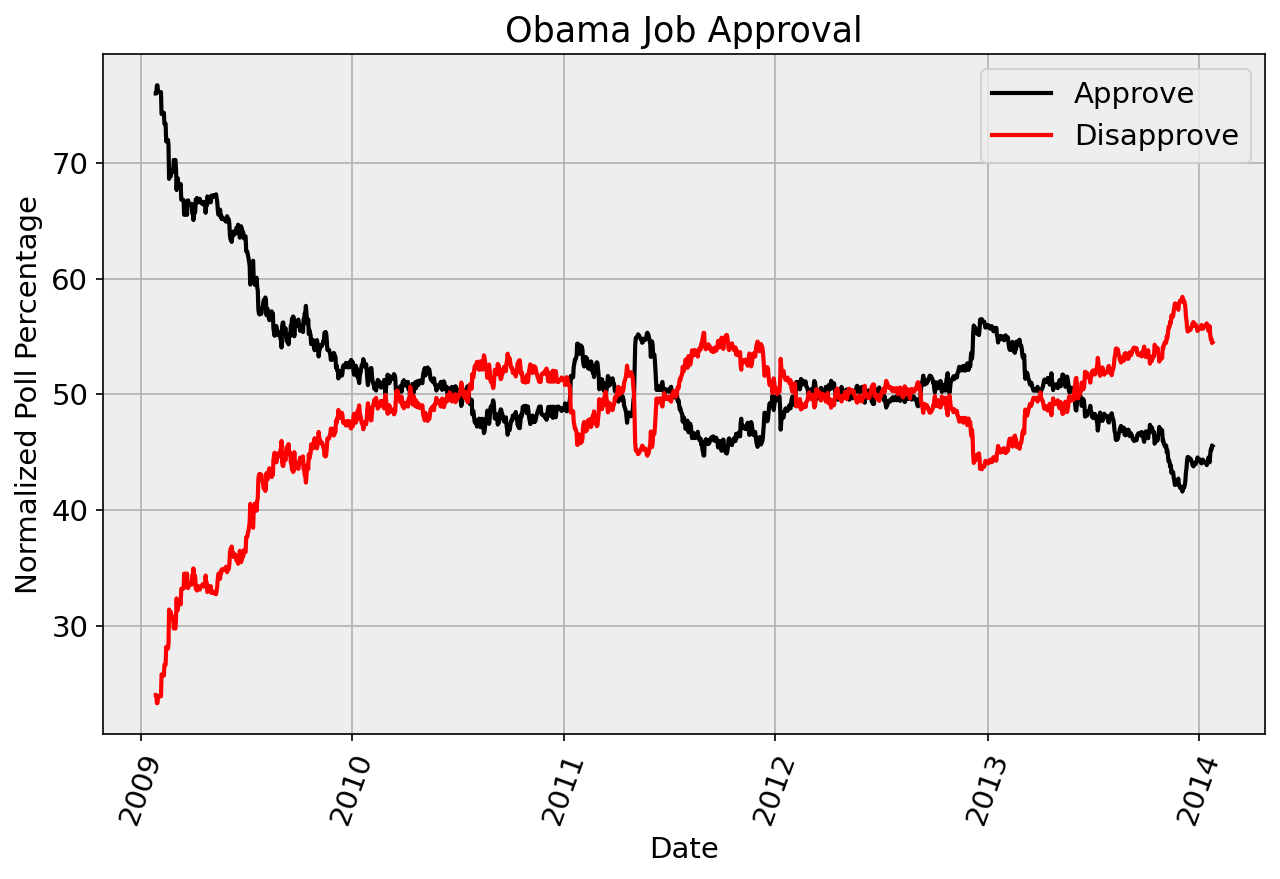

In [156]:
poll_plot(1044)
plt.title("Obama Job Approval")

#3B5998
Obama
#D30015
Romney


Text(0.5, 1.0, 'Obama vs Romney')

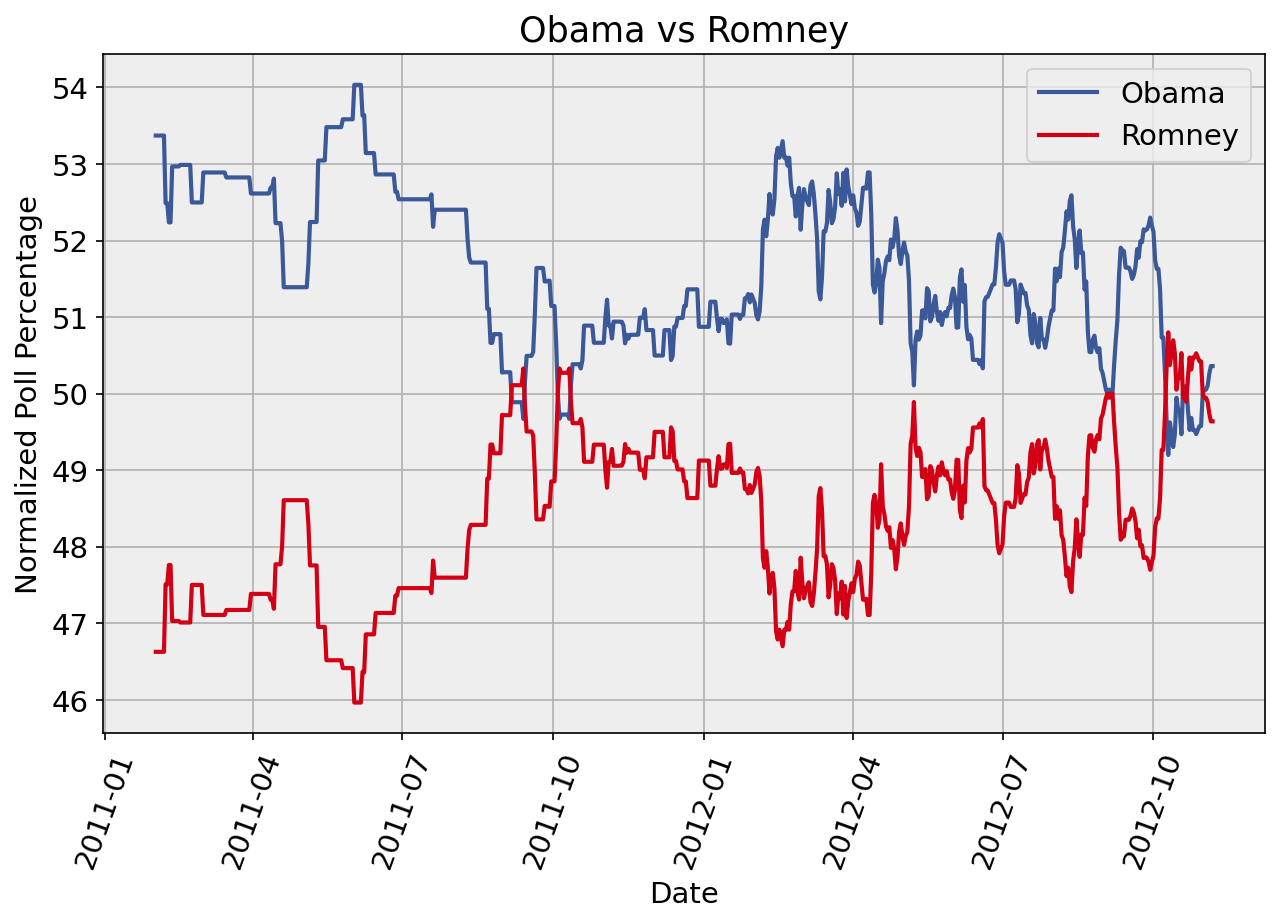

In [157]:
poll_plot(1171)
plt.title("Obama vs Romney")


## Part 2: Aggregate and Visualize


# Problem 3
Unfortunately, these data don't have any error bars. If a candidate leads by 10% in the RCP average, is she a shoo-in to win? Or is this number too close to call? Does a 10% poll lead mean more 1 day before a race than it does 1 week before? Without error estimates, these questions are impossible to answer.

To get a sense of how accurate the RCP polls are, you will gather data from many previous Governor races, where the outcome is known.

This url has links to many governer races.

http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html

Notice that each link to a governor race has the following URL pattern:

http://www.realclearpolitics.com/epolls/[YEAR]/governor/[STATE]/[TITLE]-[ID].html

Write a function that scans html for links to URLs like this

Hint The fnmatch function is useful for simple string matching tasks.

In [158]:
"""
    Function
    --------
    find_governor_races

    Find and return links to RCP races on a page like
    http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html
    
    Parameters
    ----------
    html : str
        The HTML content of a page to scan
        
    Returns
    -------
    A list of urls for Governer race pages
    
    Example
    -------
    For a page like
    
    <html>
    <body>
    <a href="http://www.realclearpolitics.com/epolls/2010/governor/ma/massachusetts_governor_baker_vs_patrick_vs_cahill-1154.html"></a>
    <a href="http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html"></a>
    </body>
    </html>
    
    find_governor_races would return
    ['http://www.realclearpolitics.com/epolls/2010/governor/ma/massachusetts_governor_baker_vs_patrick_vs_cahill-1154.html',
     'http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html']
"""
#your code here

def find_governor_races(link):
    source = urllib.request.urlopen(link).read()
    soup = bs4.BeautifulSoup(source)  
   ## get all links in the page
    link_list = [l.get('href') for l in soup.findAll('a')]
    link_list = [l for l in link_list if l is not None and l.startswith('/epolls/2010/governor/')]
    url_firstpart = 'http://www.realclearpolitics.com'
    link_list2 = [url_firstpart + elem for elem in link_list]
    return link_list2



In [145]:
url = "https://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html"
find_governor_races(url)

find_governor_races(url)

['http://www.realclearpolitics.com/epolls/2010/governor/ar/arkansas_governor_keet_vs_beebe-1568.html',
 'http://www.realclearpolitics.com/epolls/2010/governor/md/maryland_governor_ehrlich_vs_omalley-1121.html',
 'http://www.realclearpolitics.com/epolls/2010/governor/ny/new_york_governor_paladino_vs_cuomo-1423.html',
 'http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html',
 'http://www.realclearpolitics.com/epolls/2010/governor/nh/new_hampshire_governor_stephen_vs_lynch-1446.html',
 'http://www.realclearpolitics.com/epolls/2010/governor/co/colorado_governor_maes_vs_hickenlooper_vs_tancredo-1677.html',
 'http://www.realclearpolitics.com/epolls/2010/governor/ct/connecticut_governor_foley_vs_malloy-1357.html',
 'http://www.realclearpolitics.com/epolls/2010/governor/fl/florida_governor_scott_vs_sink_vs_chiles-1607.html',
 'http://www.realclearpolitics.com/epolls/2010/governor/hi/hawaii_governor_aiona_vs_abercrombie-1163.html',
 'http://www.

#D30015
Sandoval
#3B5998
Reid
#D30015
Sandoval
#3B5998
Reid


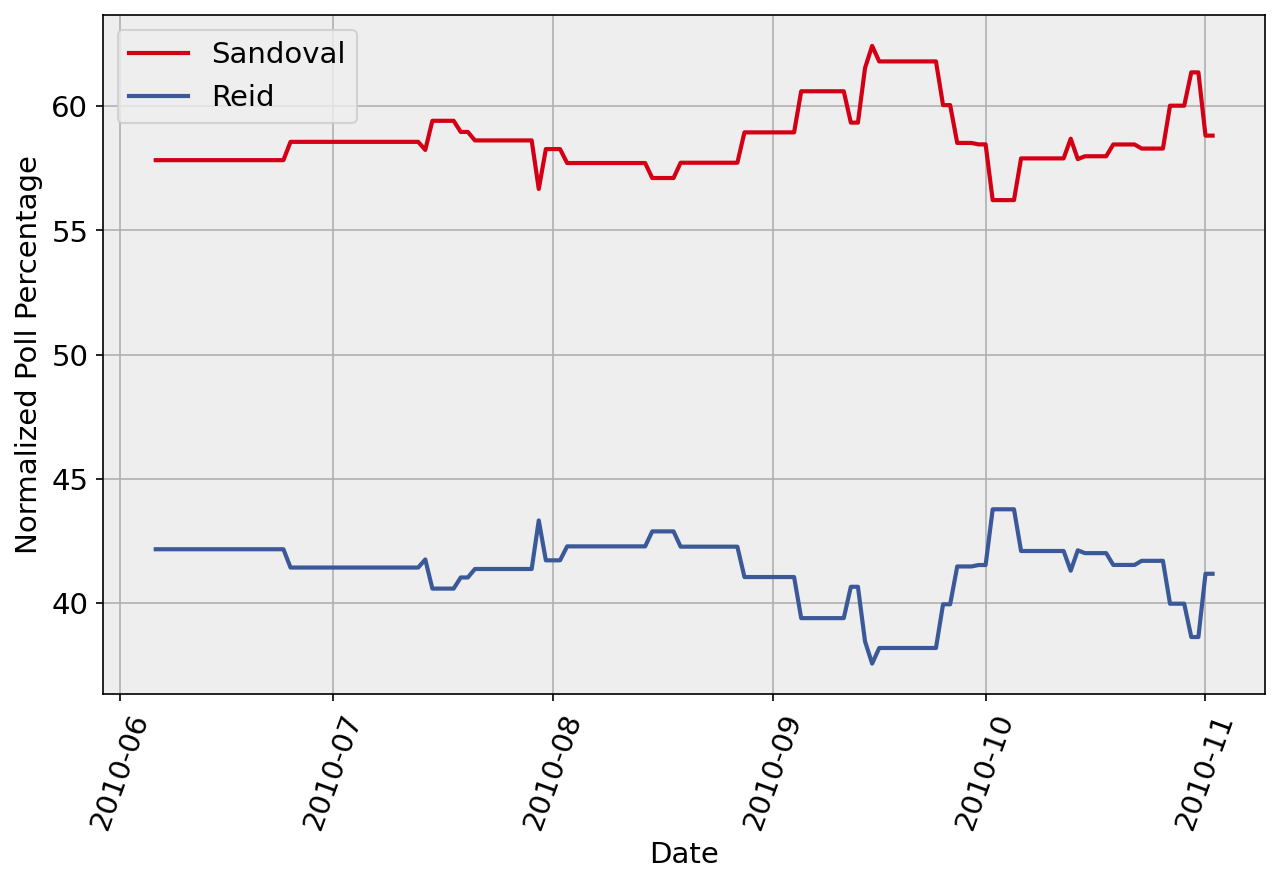

In [159]:
poll2 = get_poll_xml(1137)
plot_colors(poll2)
rcp_poll_data(poll2)
poll_plot(1137)



# Problem 4

At this point, you have functions to find a collection of governor races, download historical polling data from each one,
parse them into a numerical DataFrame, and plot this data.

The main question we have about these data are how accurately they predict election outcomes. To answer this question, we
need to grab the election outcome data.

Write a function that looks up and returns the election result on a page like [this one](http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html). 

**Remember to look at the HTML source!**

You can do this by selection `view->developer->view source` in Chrome, or `Tools -> web developer -> page source` in Firefox. Altenatively, you can right-click on a part of the page, and select "inspect element"

In [164]:
"""
    Function
    --------
    race_result

    Return the actual voting results on a race page
    
    Parameters
    ----------
    url : string
        The website to search through
        
    Returns
    -------
    A dictionary whose keys are candidate names,
    and whose values is the percentage of votes they received.
    
    If necessary, normalize these numbers so that they add up to 100%.
    
    Example
    --------
    >>> url = 'http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html'
    >>> race_result(url)
    {'Brown': 56.0126582278481, 'Whitman': 43.9873417721519}
"""
#your code here



def race_result(link):
    source2 = urllib.request.urlopen(link).read()
    soup2 = bs(source2)  
    
    polling_data_rcp = soup2.findAll('table', {'class': "data"})[0]
    
    results = {}
    for i in range(3,5):
        candidate = (polling_data_rcp.findChild().findChildren()[i]).text
        candidate = candidate.replace('(D)', '').replace('(R)', '').replace('(I)', '')
        result = (polling_data_rcp.findChild().findNextSibling().findChildren()[i+1]).text
        result = float(result)
        results[candidate] = result
    
    perc = list(results.values())    
    tot = sum(perc)
    #print(tot)

    array_perc = np.array(perc, dtype=float)
    #print(array_perc)

    norm_arrary_perc = (array_perc / tot)*100
    #print(norm_arrary_perc)

    candidates = list(results.keys())

    results_norm = {candidates[0]: [norm_arrary_perc[0]], candidates[1]: [norm_arrary_perc[1]]}
    result_norm_Df = pd.DataFrame(results_norm)


    return result_norm_Df
    


In [161]:
race_result("https://www.realclearpolitics.com/epolls/2010/governor/nv/nevada_governor_sandoval_vs_reid-1137.html")


,Reid,Sandoval
0,43.789474,56.210526


### Here are some more utility functions that take advantage of what you've done so far.

In [162]:
# "r"egular "e"xpressions is kind of a mini-language to
# do pattern matching on text
import re

def _strip(s):
    """This function removes non-letter characters from a word
    
    for example _strip('Hi there!') == 'Hi there'
    """
    return re.sub(r'[\W_]+', '', s)


def id_from_url(url):
    """Given a URL, look up the RCP identifier number"""
    return url.split('-')[-1].split('.html')[0]


def plot_race(url):
    """Make a plot summarizing a senate race
    
    Overplots the actual race results as dashed horizontal lines
    """
    #hey, thanks again for these functions!
    id = id_from_url(url)
    xml = get_poll_xml(id)    
    colors = plot_colors(xml)

    if len(colors) == 0:
        return
    
    #really, you shouldn't have
    result = race_result(url)
    print(result)
    
    poll_plot(id)
    plt.xlabel("Date")
    plt.ylabel("Polling Percentage")
    for r in result:
        plt.axhline(result[r].tolist()[0], color=colors[_strip(r)], alpha=0.6, ls='--')
       

       Reid   Sandoval 
0  43.789474  56.210526


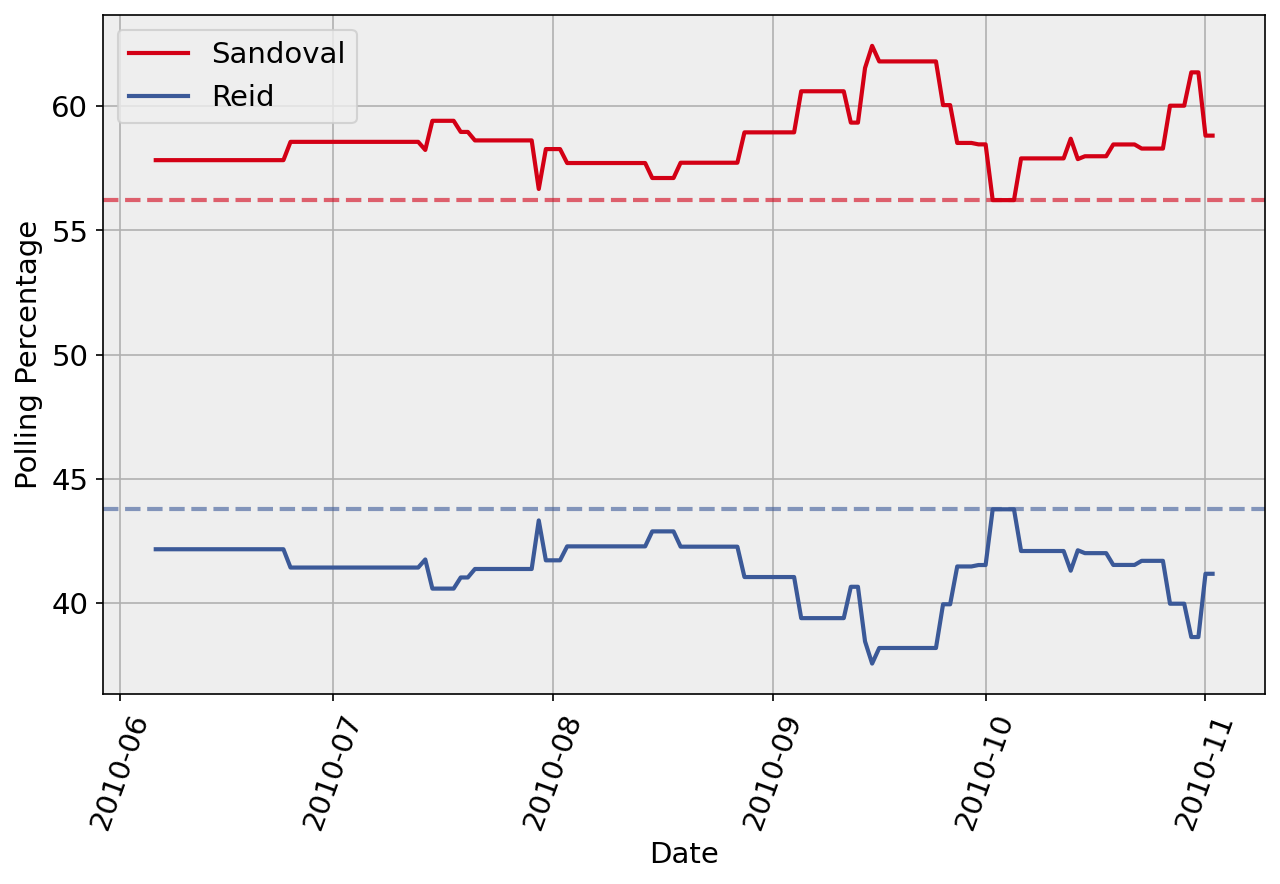

In [118]:
plot_race("https://www.realclearpolitics.com/epolls/2010/governor/nv/nevada_governor_sandoval_vs_reid-1137.html")


Now that this is done, we can easily visualize many historical Governer races. The solid line plots the poll history, the dotted line reports the actual result.

If this code block fails, you probably have a bug in one of your functions.

In [171]:
url = "https://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html"
governor_races_list = find_governor_races(url)
#tuve que sacar una de las paginas porque era la unica que tenia una página distinta, y en vez de table: class: data, decia table: class: data large...
governor_races_list.remove('http://www.realclearpolitics.com/epolls/2010/governor/tx/texas_governor_perry_vs_white-1194.html')

governor_races_list

['http://www.realclearpolitics.com/epolls/2010/governor/ar/arkansas_governor_keet_vs_beebe-1568.html',
 'http://www.realclearpolitics.com/epolls/2010/governor/md/maryland_governor_ehrlich_vs_omalley-1121.html',
 'http://www.realclearpolitics.com/epolls/2010/governor/ny/new_york_governor_paladino_vs_cuomo-1423.html',
 'http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html',
 'http://www.realclearpolitics.com/epolls/2010/governor/nh/new_hampshire_governor_stephen_vs_lynch-1446.html',
 'http://www.realclearpolitics.com/epolls/2010/governor/co/colorado_governor_maes_vs_hickenlooper_vs_tancredo-1677.html',
 'http://www.realclearpolitics.com/epolls/2010/governor/ct/connecticut_governor_foley_vs_malloy-1357.html',
 'http://www.realclearpolitics.com/epolls/2010/governor/fl/florida_governor_scott_vs_sink_vs_chiles-1607.html',
 'http://www.realclearpolitics.com/epolls/2010/governor/hi/hawaii_governor_aiona_vs_abercrombie-1163.html',
 'http://www.

#3B5998
Beebe
#D30015
Keet
      Beebe       Keet 
0  65.749235  34.250765
#3B5998
Beebe
#D30015
Keet


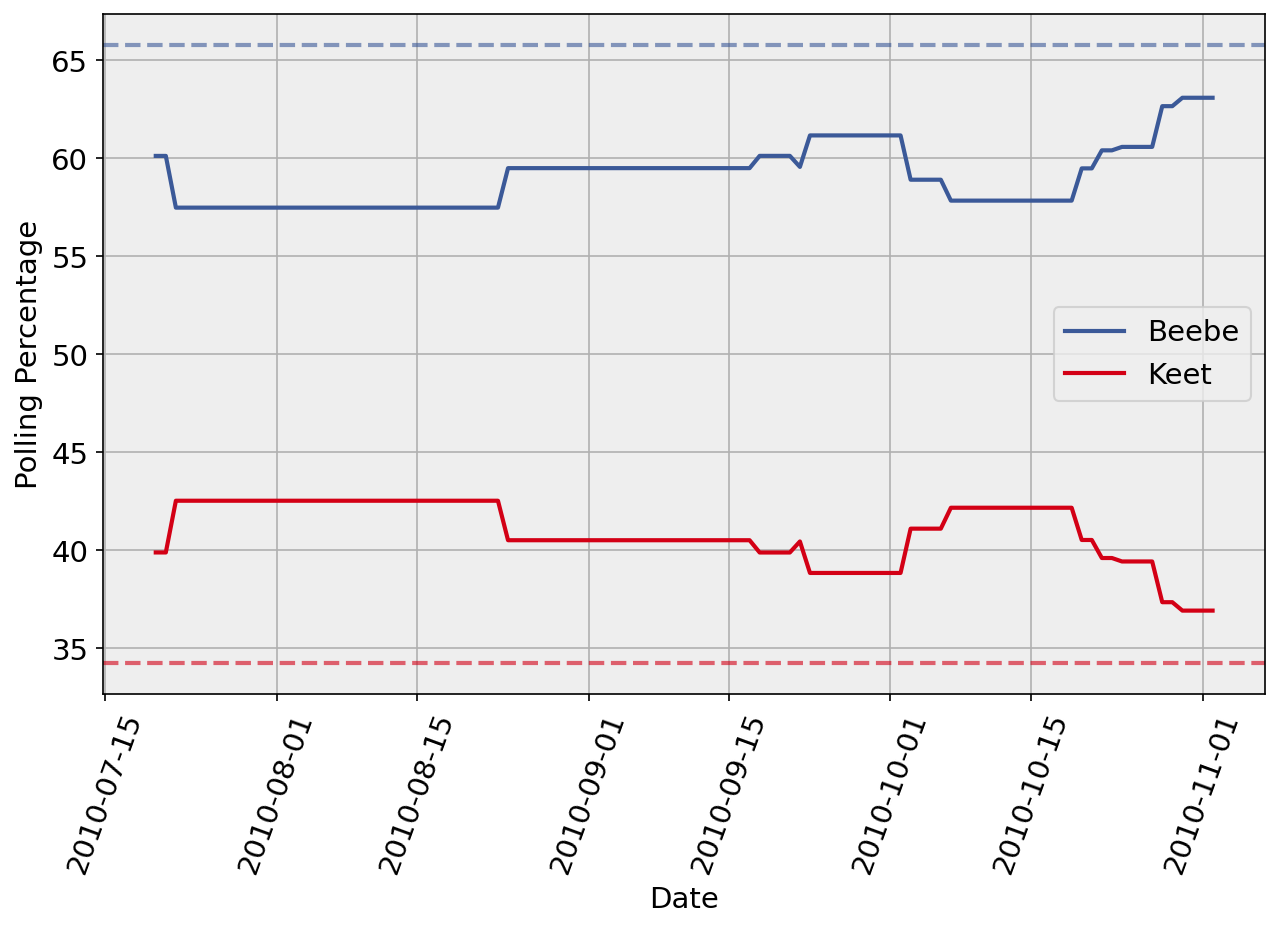

#3B5998
OMalley
#D30015
Ehrlich
    Ehrlich   O'Malley 
0  43.119266  56.880734
#3B5998
OMalley
#D30015
Ehrlich


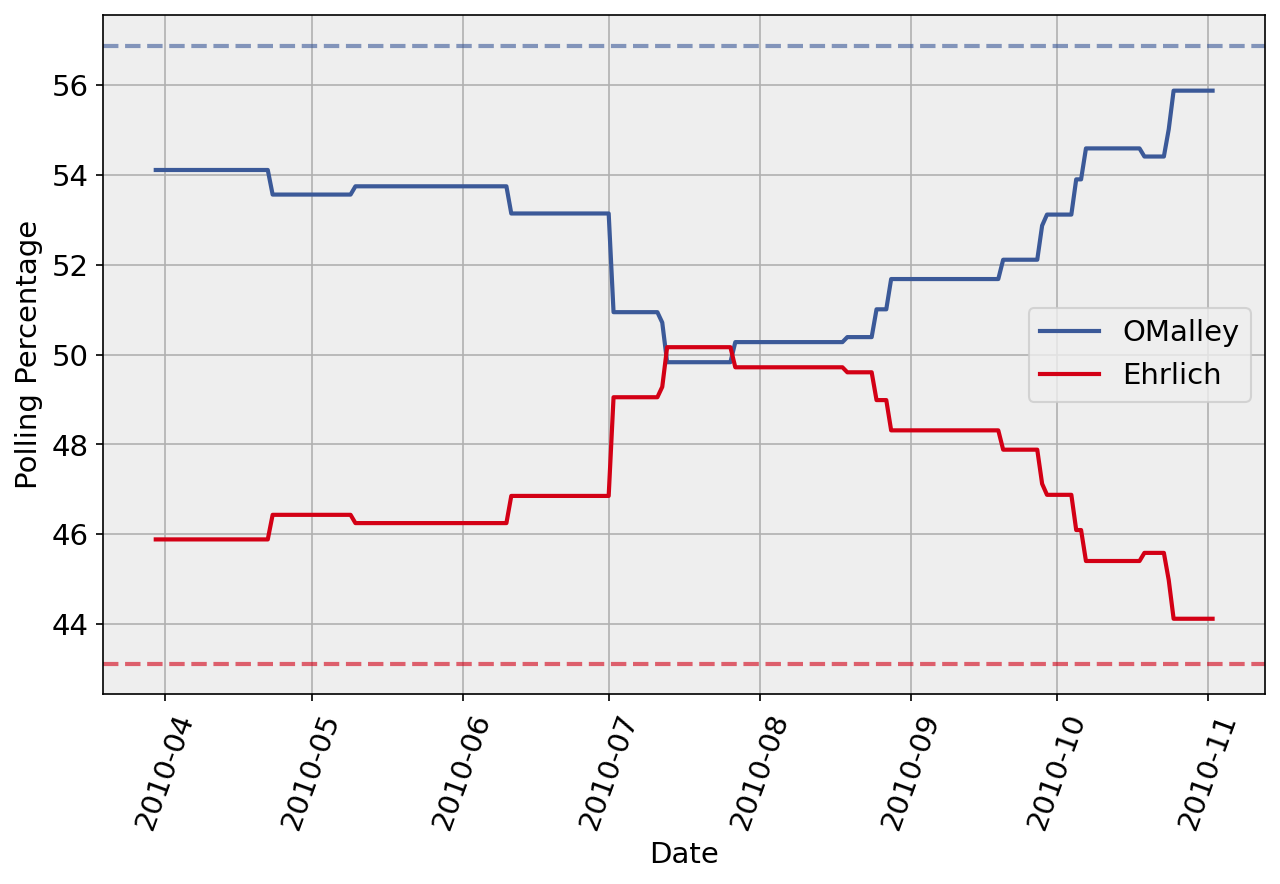

#3B5998
Cuomo
#D30015
Paladino
      Cuomo   Paladino 
0  64.293194  35.706806
#3B5998
Cuomo
#D30015
Paladino


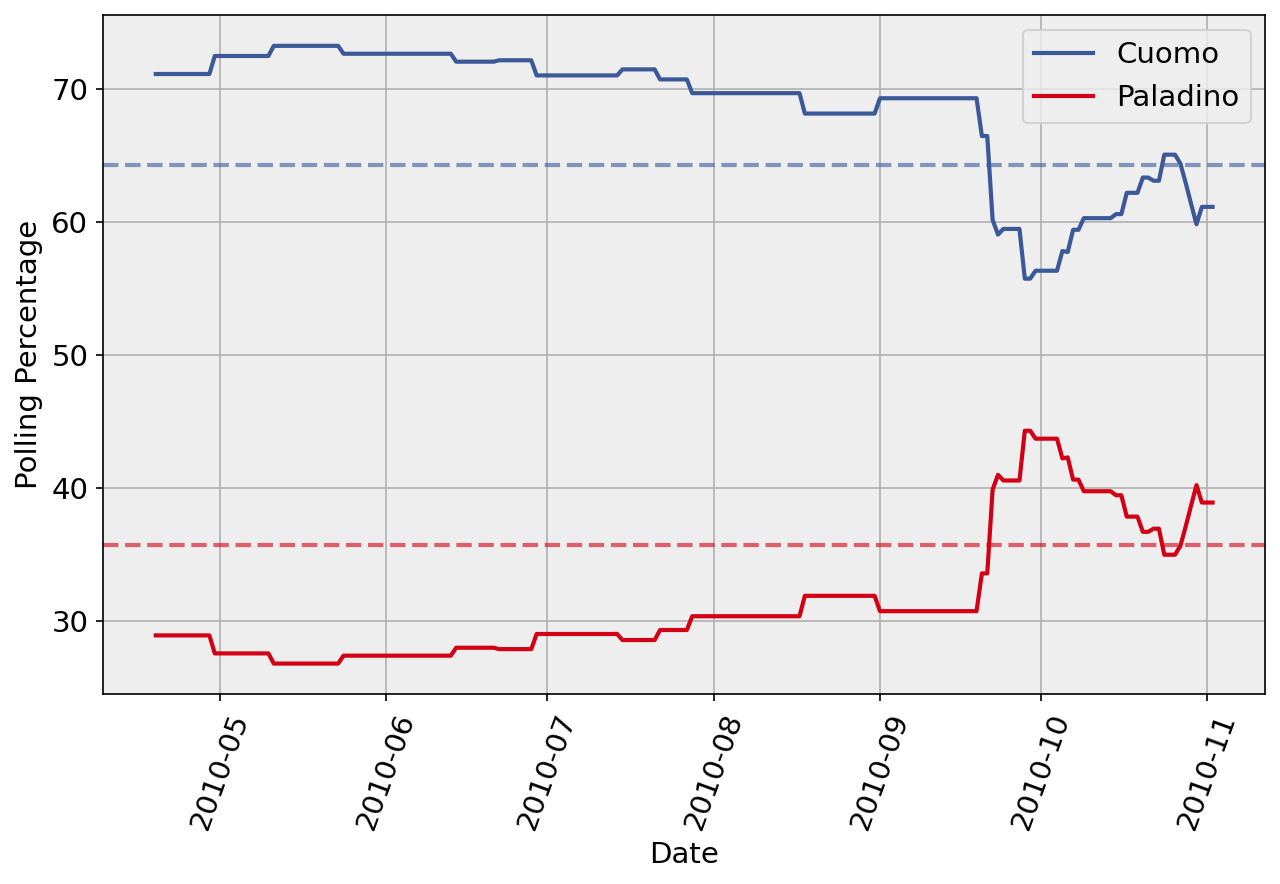

#3B5998
Brown
#D30015
Whitman
      Brown    Whitman 
0  56.012658  43.987342
#3B5998
Brown
#D30015
Whitman


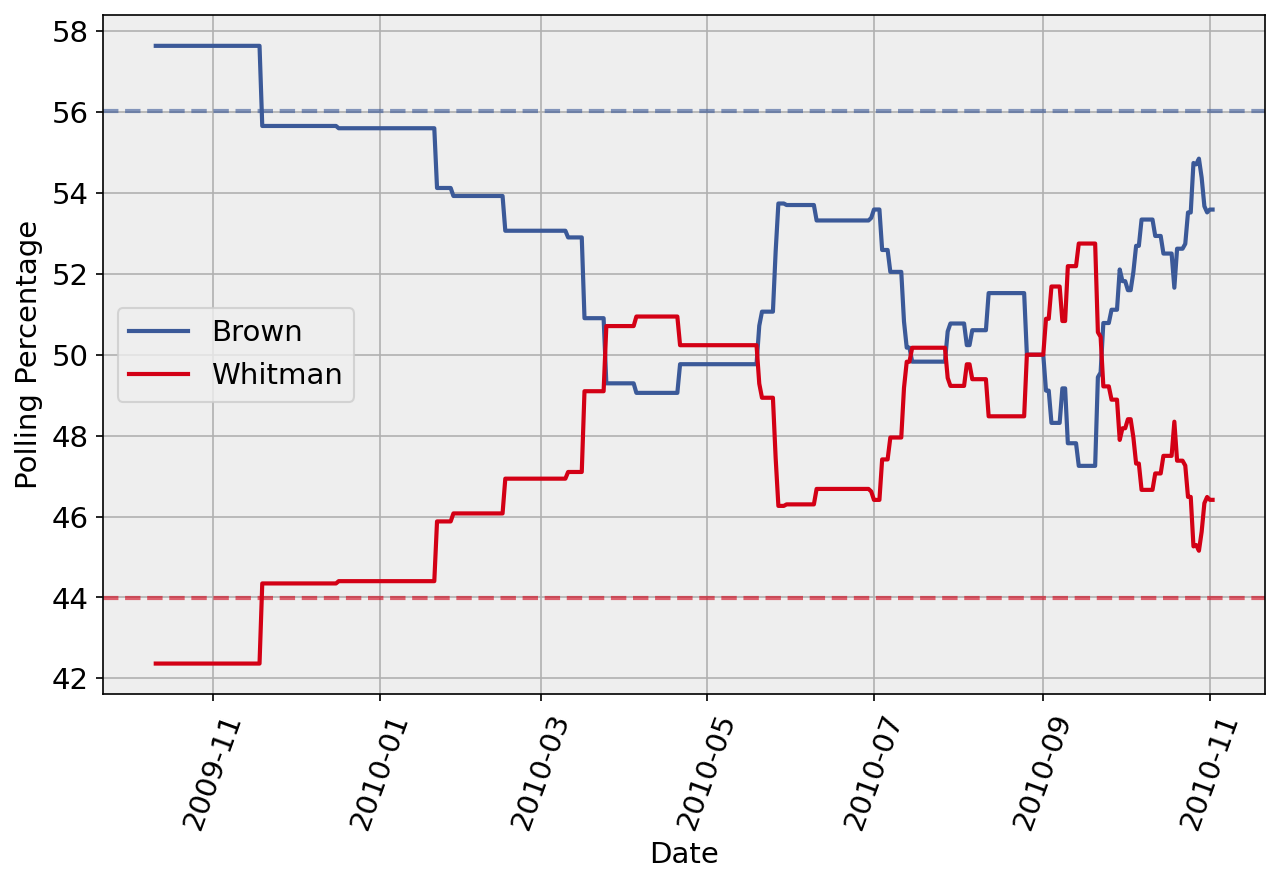

#3B5998
Lynch
#D30015
Stephen
     Lynch   Stephen 
0  53.83828  46.16172
#3B5998
Lynch
#D30015
Stephen


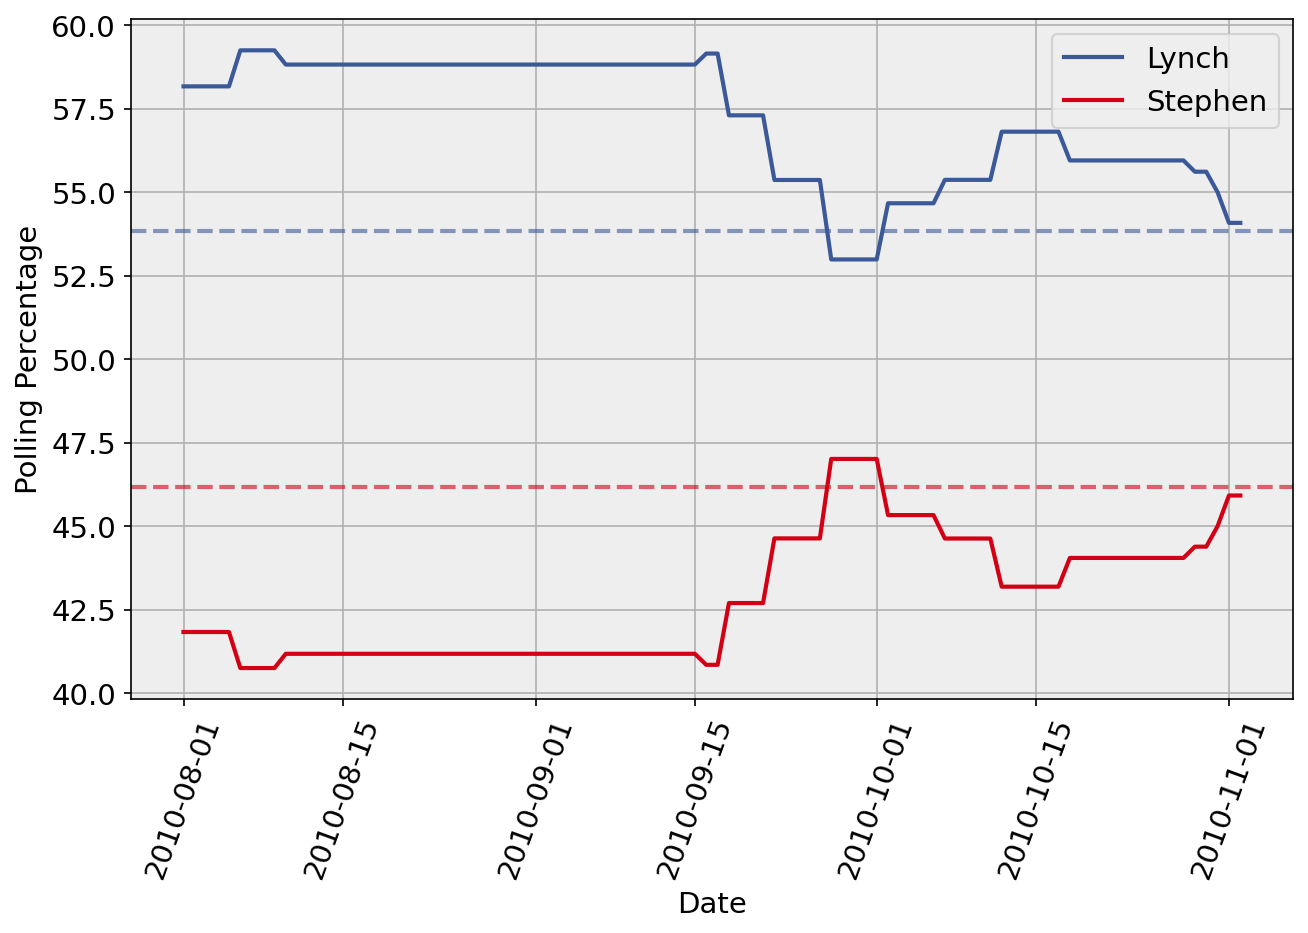

#3B5998
Hickenlooper
#990000
Tancredo
#D30015
Maes
   Hickenlooper       Maes 
0      82.038835  17.961165
#3B5998
Hickenlooper
#990000
Tancredo
#D30015
Maes


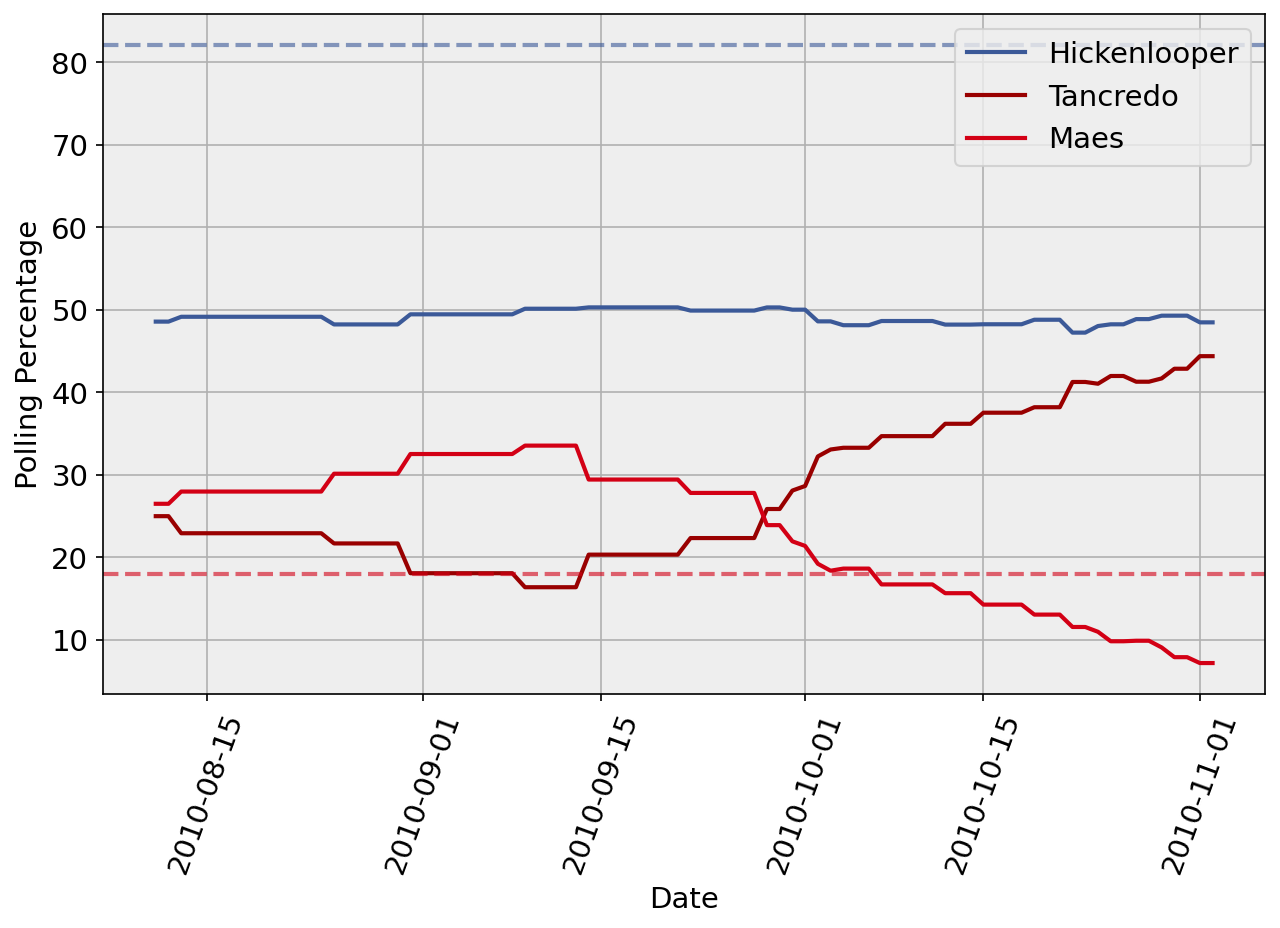

#D30015
Foley
#3B5998
Malloy
     Foley    Malloy 
0  49.64467  50.35533
#D30015
Foley
#3B5998
Malloy


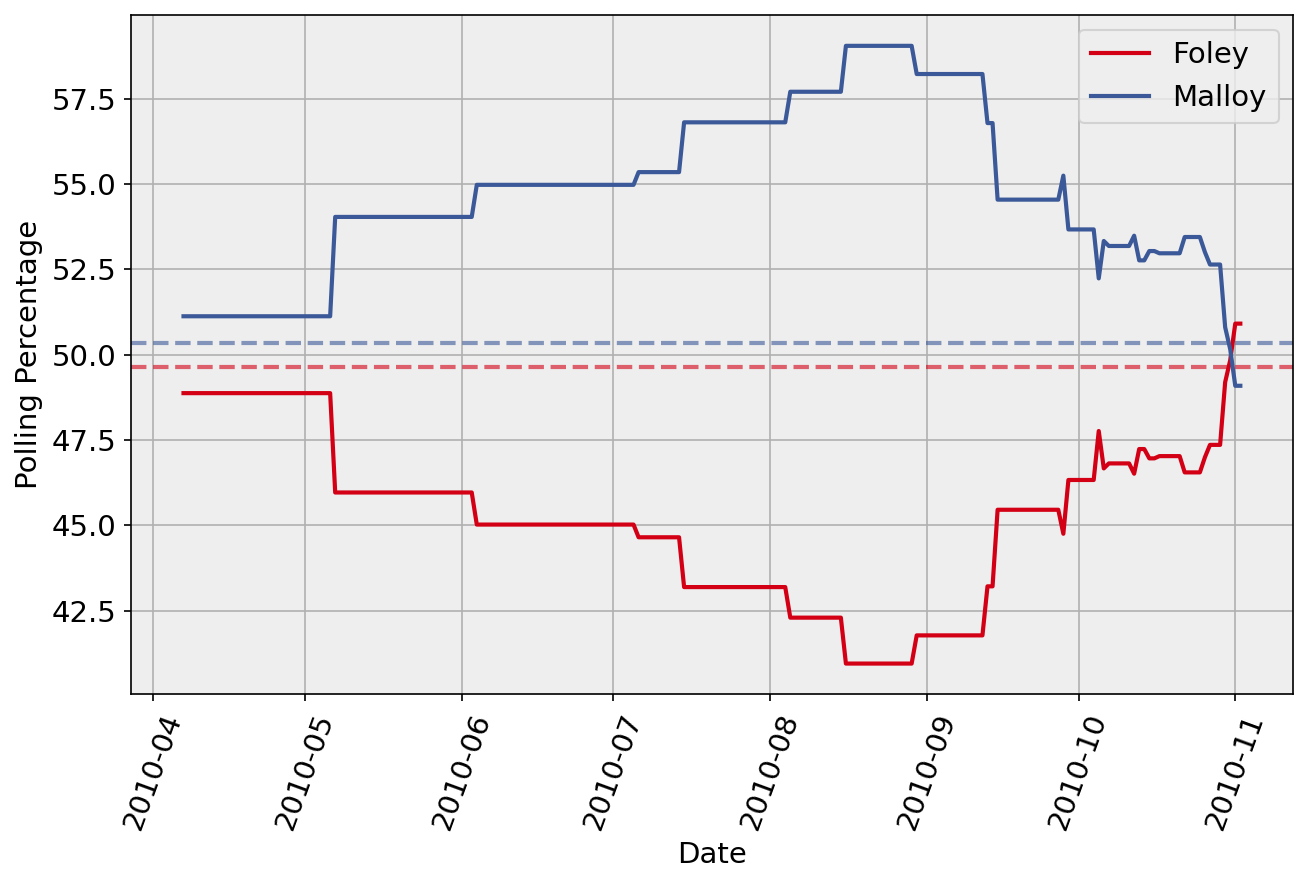

#D30015
Scott
#3B5998
Sink
      Scott       Sink 
0  50.621118  49.378882
#D30015
Scott
#3B5998
Sink


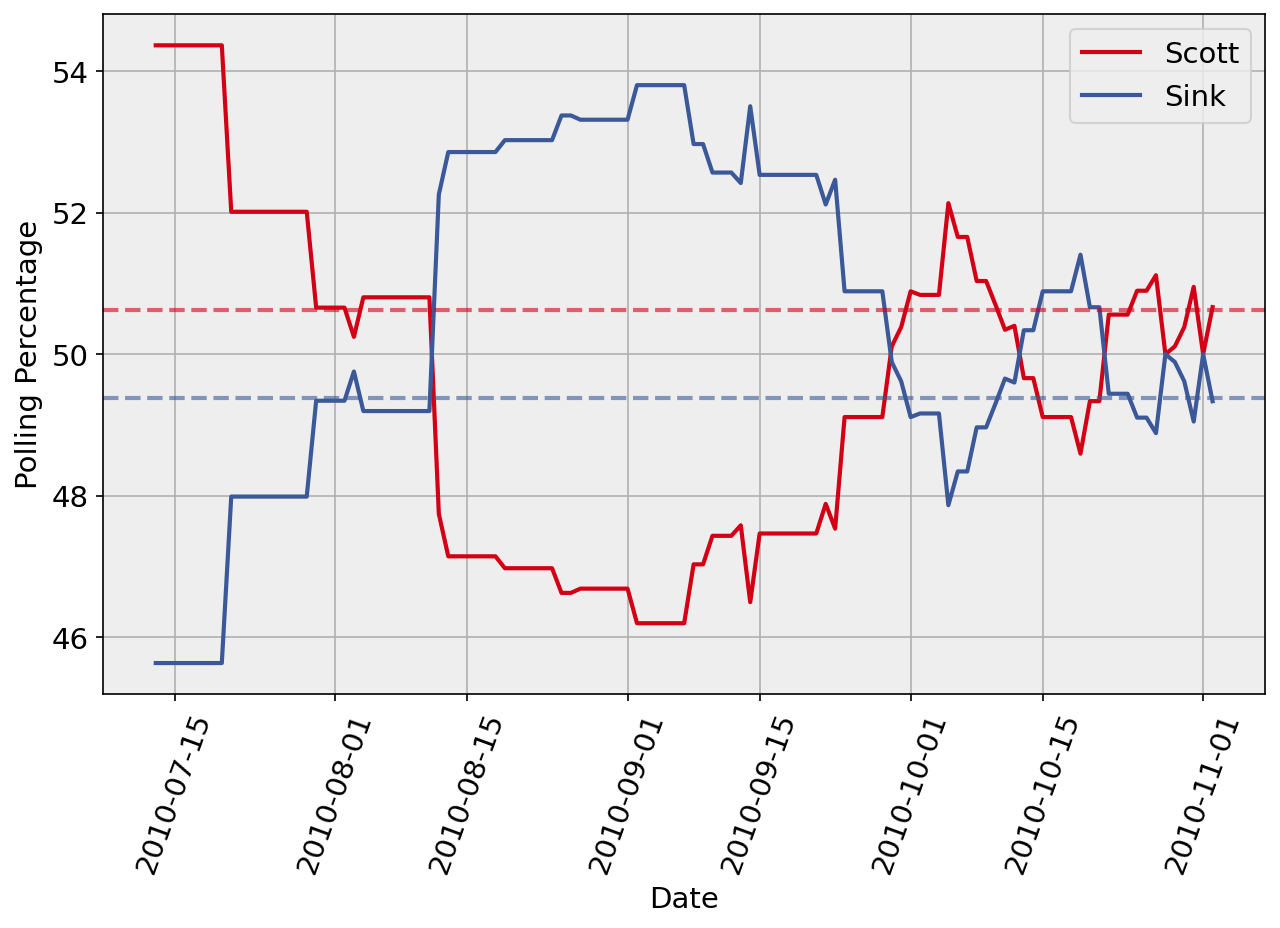

#D30015
Brady
#3B5998
Quinn
      Brady      Quinn 
0  49.730313  50.269687
#D30015
Brady
#3B5998
Quinn


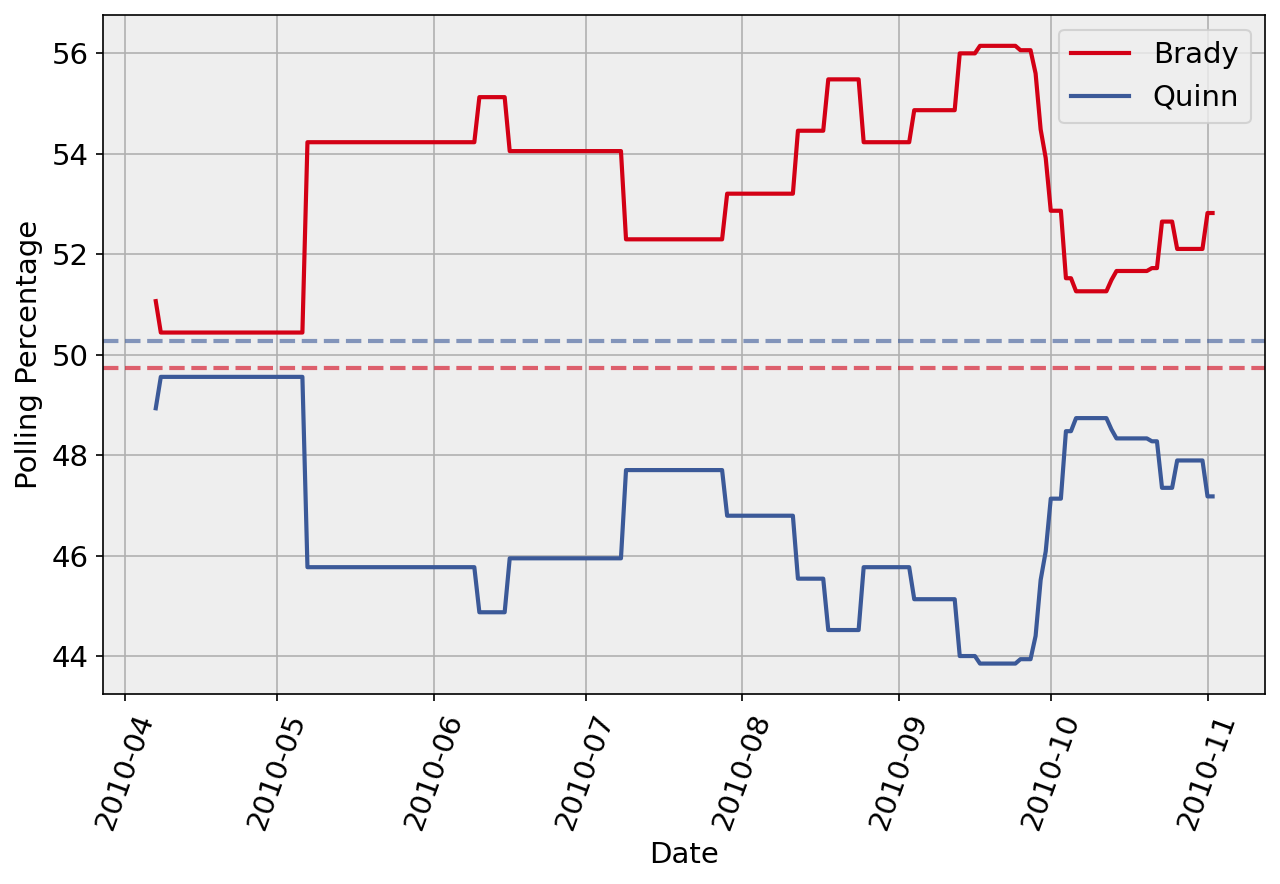

#3B5998
Patrick
#D30015
Baker
#000000
Cahill
      Baker     Cahill 
0  84.031936  15.968064
#3B5998
Patrick
#D30015
Baker
#000000
Cahill


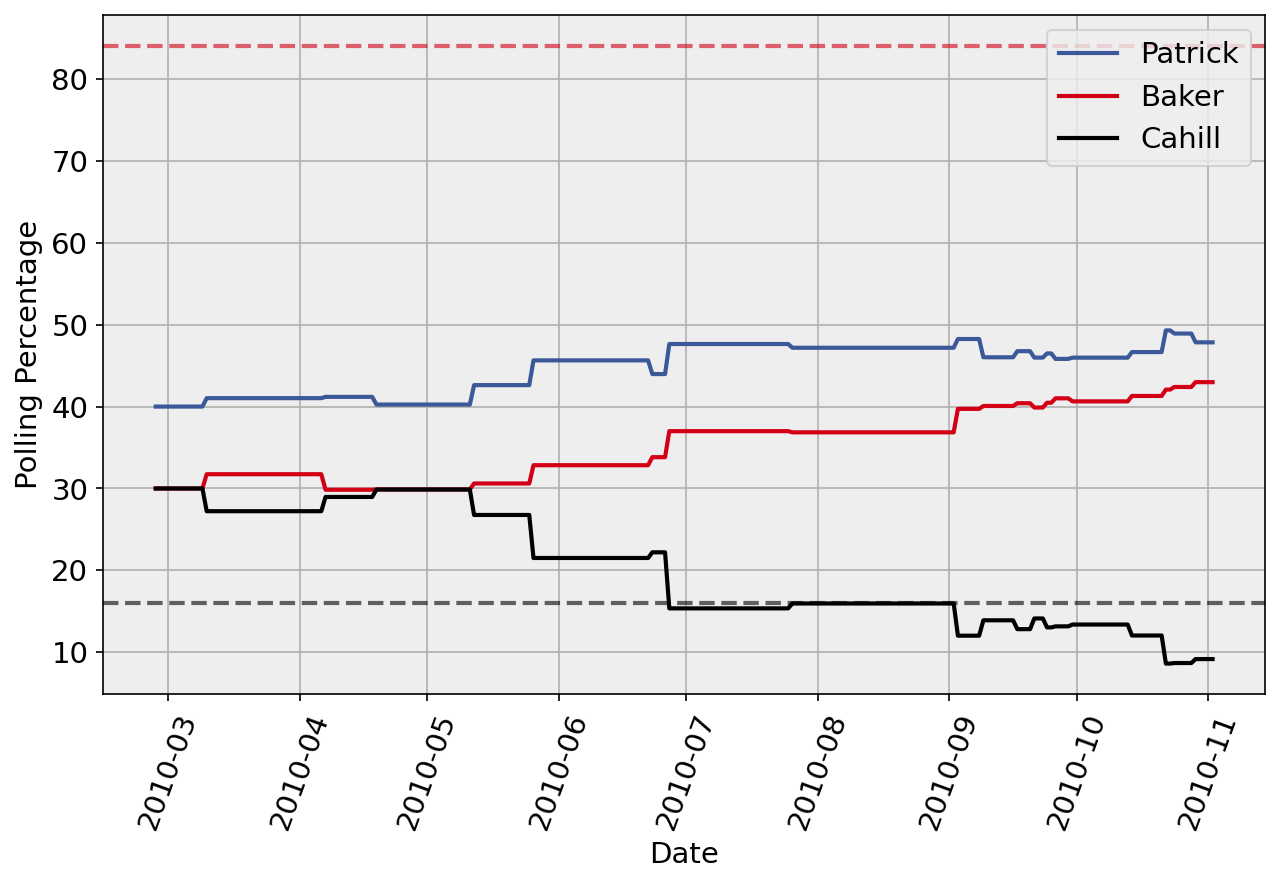

#3B5998
Dayton
#D30015
Emmer
#000000
Horner
     Dayton      Emmer 
0  50.287687  49.712313
#3B5998
Dayton
#D30015
Emmer
#000000
Horner


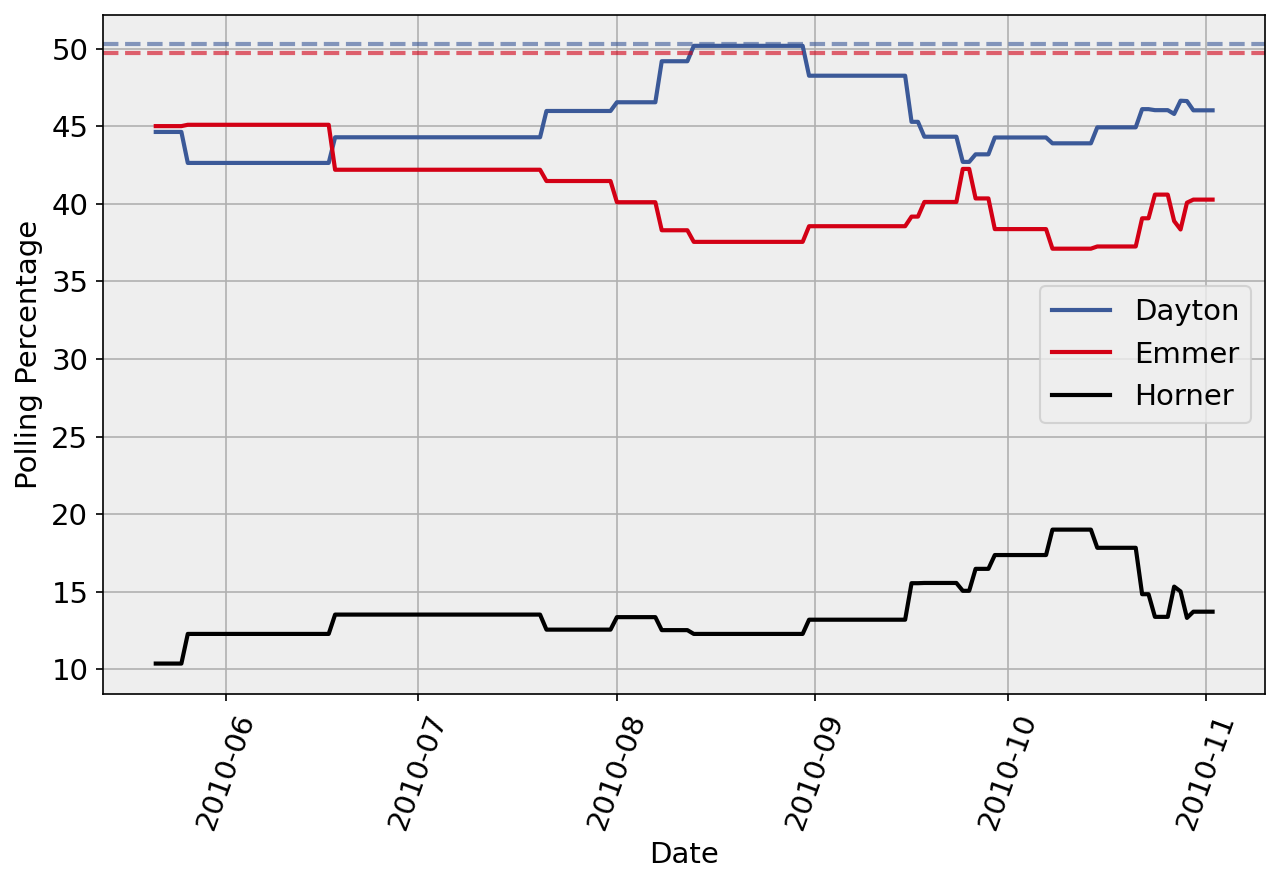

#D30015
Kasich
#3B5998
Strickland
     Kasich   Strickland 
0  51.404787    48.595213
#D30015
Kasich
#3B5998
Strickland


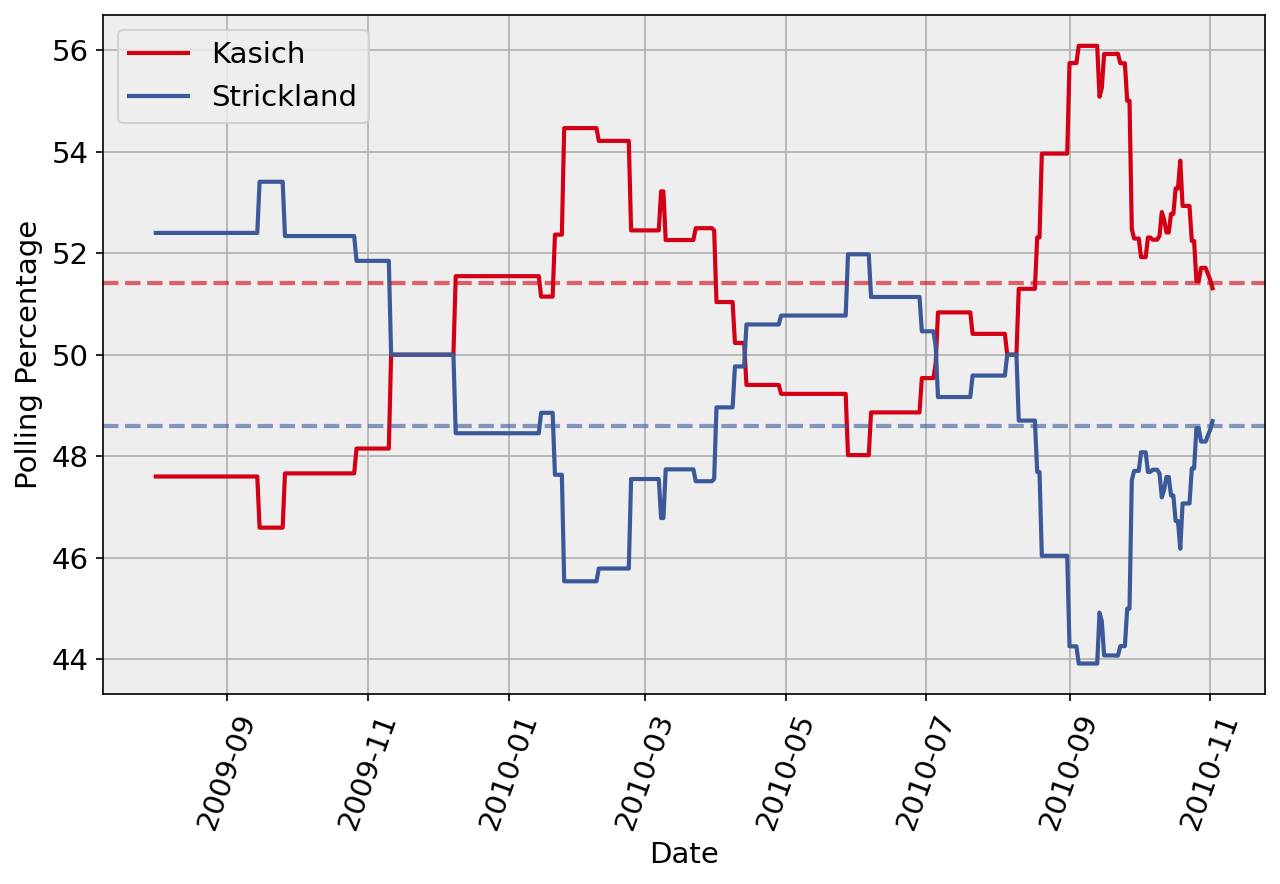

#3B5998
Kitzhaber
#D30015
Dudley
     Dudley   Kitzhaber 
0  49.434738   50.565262
#3B5998
Kitzhaber
#D30015
Dudley


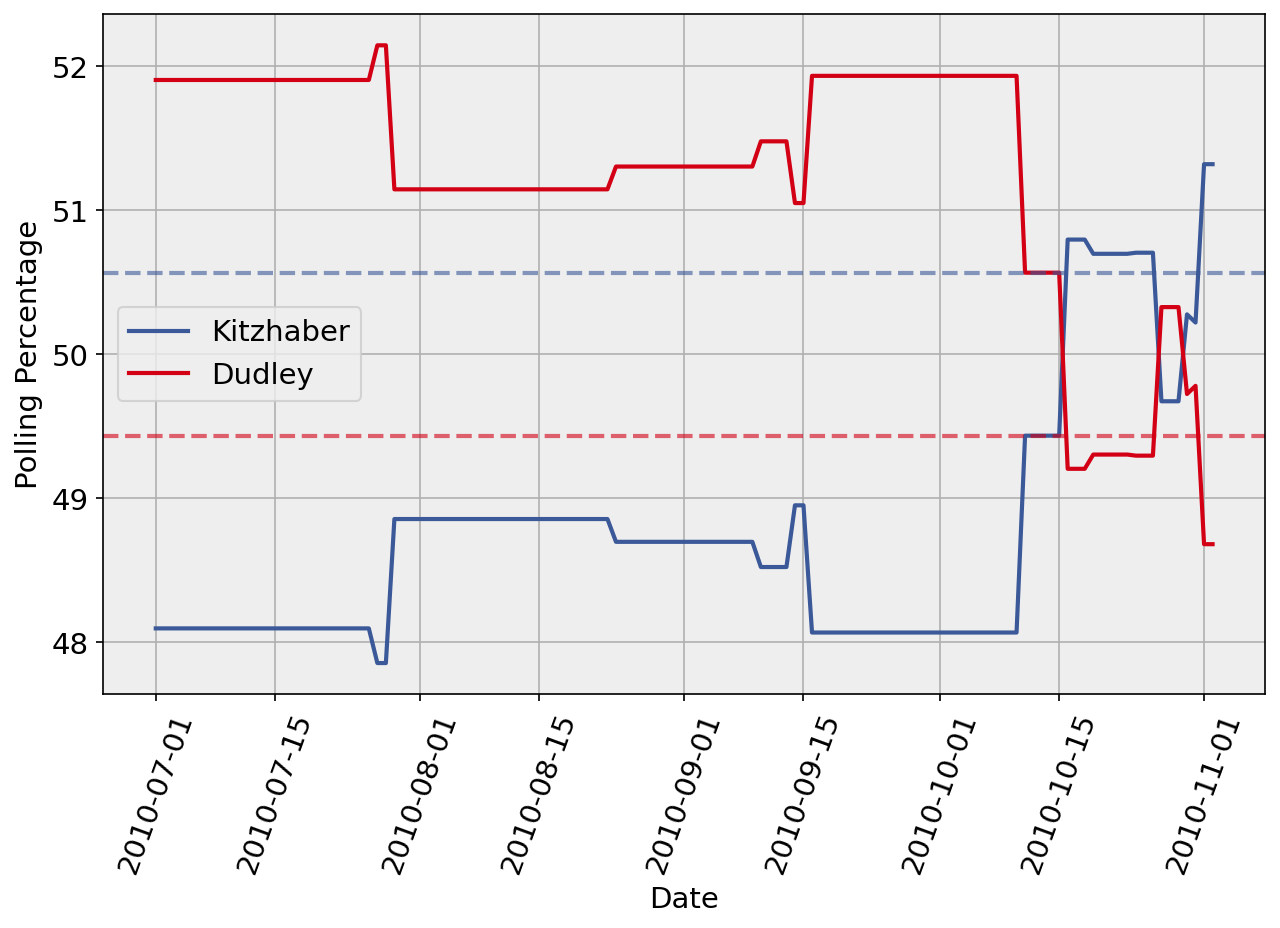

#009900
Chafee
#D30015
Robitaille
#3B5998
Caprio
    Caprio    Chafee 
0  38.91709  61.08291
#009900
Chafee
#D30015
Robitaille
#3B5998
Caprio


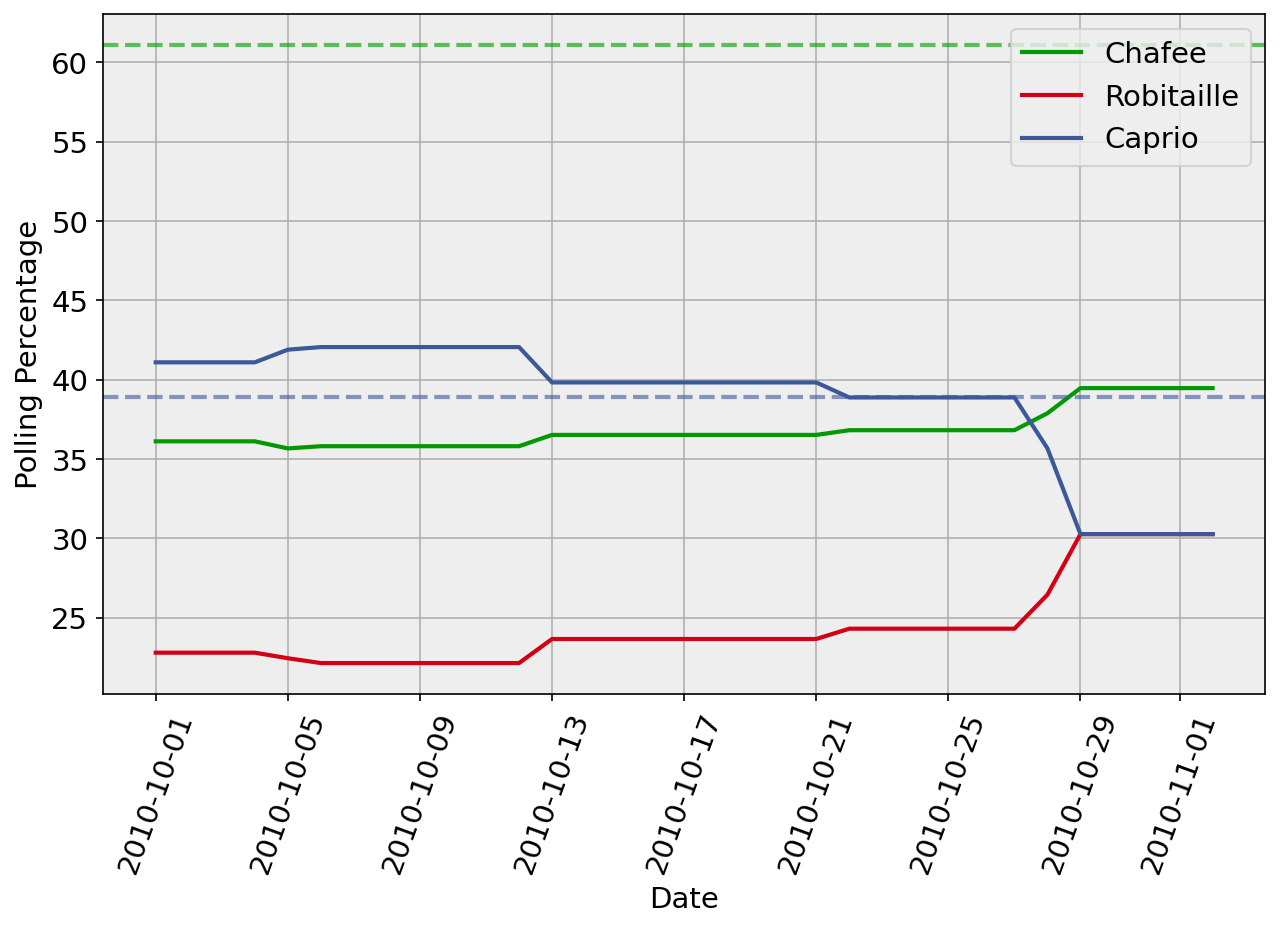

#D30015
Brewer
#3B5998
Goddard
     Brewer    Goddard 
0  56.449948  43.550052
#D30015
Brewer
#3B5998
Goddard


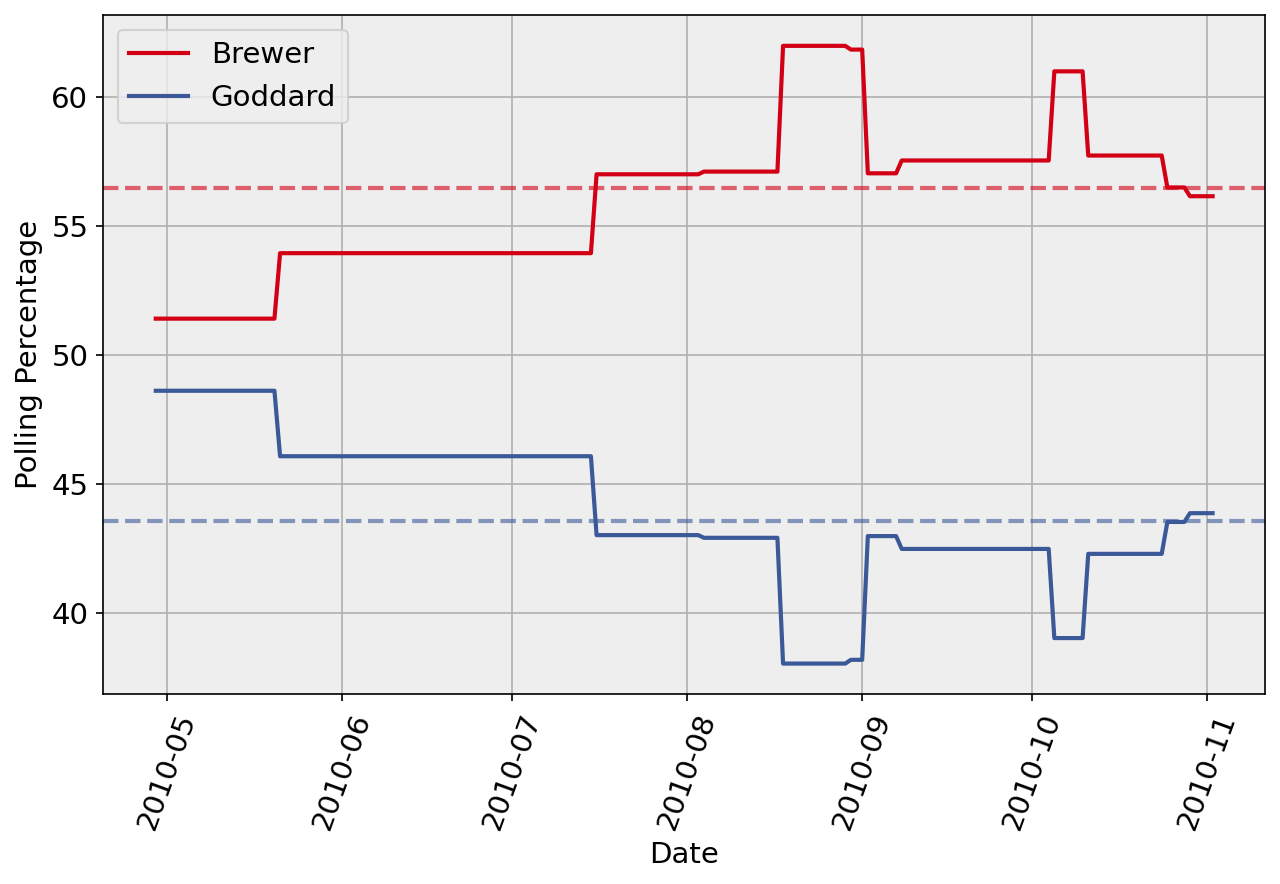

#D30015
Deal
#3B5998
Barnes
     Barnes       Deal 
0  44.895833  55.104167
#D30015
Deal
#3B5998
Barnes


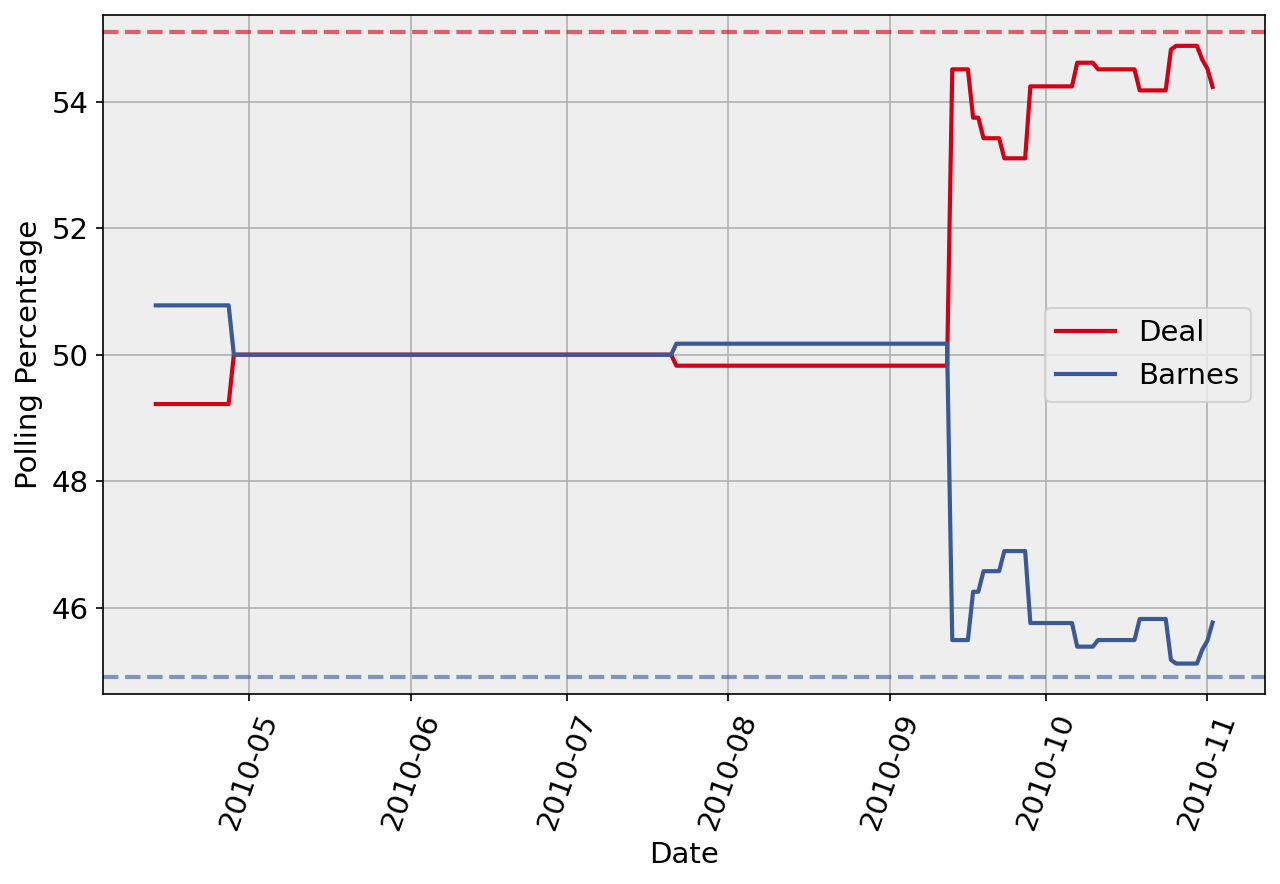

#D30015
Martinez
#3B5998
Denish
   Denish   Martinez 
0     46.4       53.6
#D30015
Martinez
#3B5998
Denish


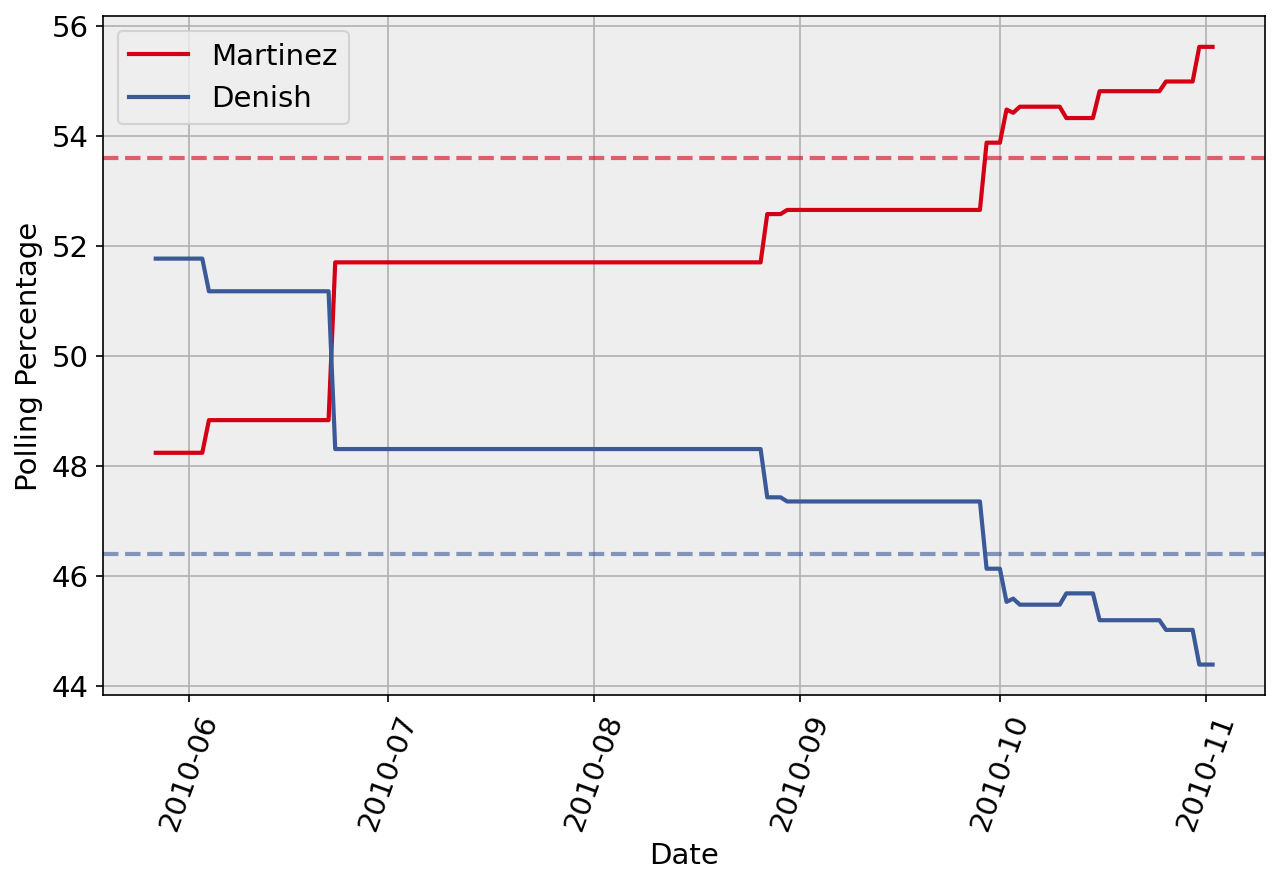

#D30015
Corbett
#3B5998
Onorato
   Corbett   Onorato 
0      54.5      45.5
#D30015
Corbett
#3B5998
Onorato


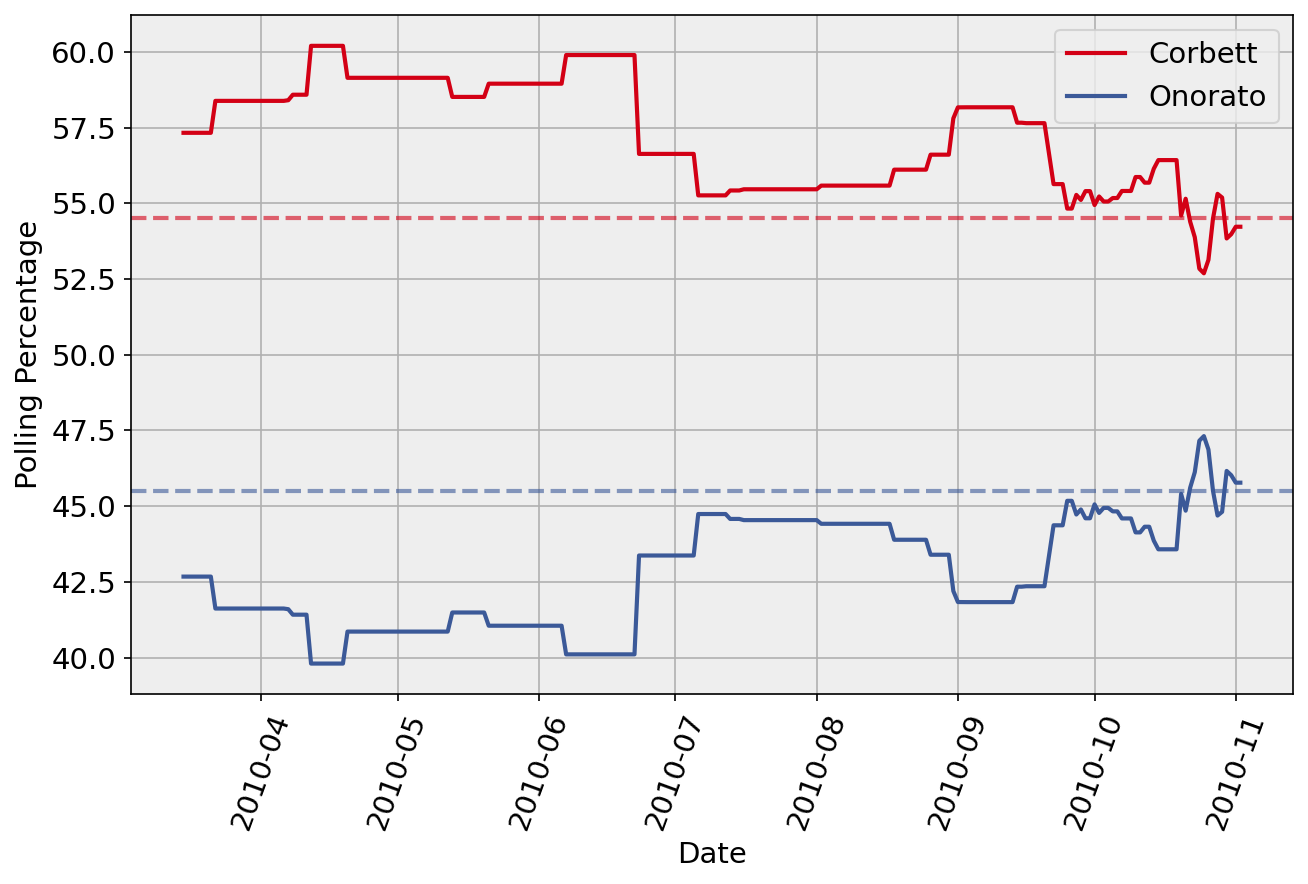

#D30015
Haley
#3B5998
Sheheen
      Haley    Sheheen 
0  52.182741  47.817259
#D30015
Haley
#3B5998
Sheheen


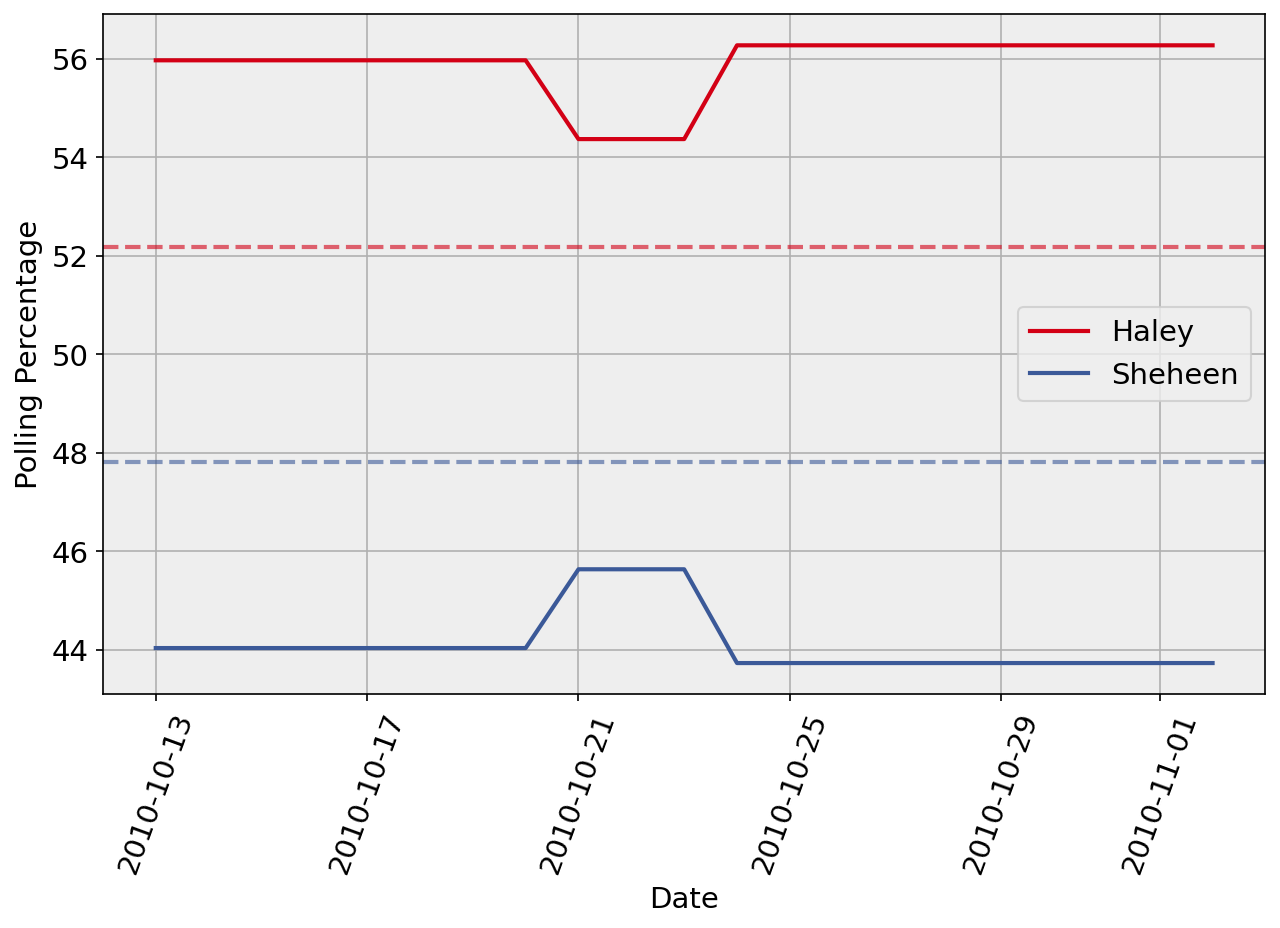

#D30015
Walker
#3B5998
Barrett
    Barrett     Walker 
0  47.118301  52.881699
#D30015
Walker
#3B5998
Barrett


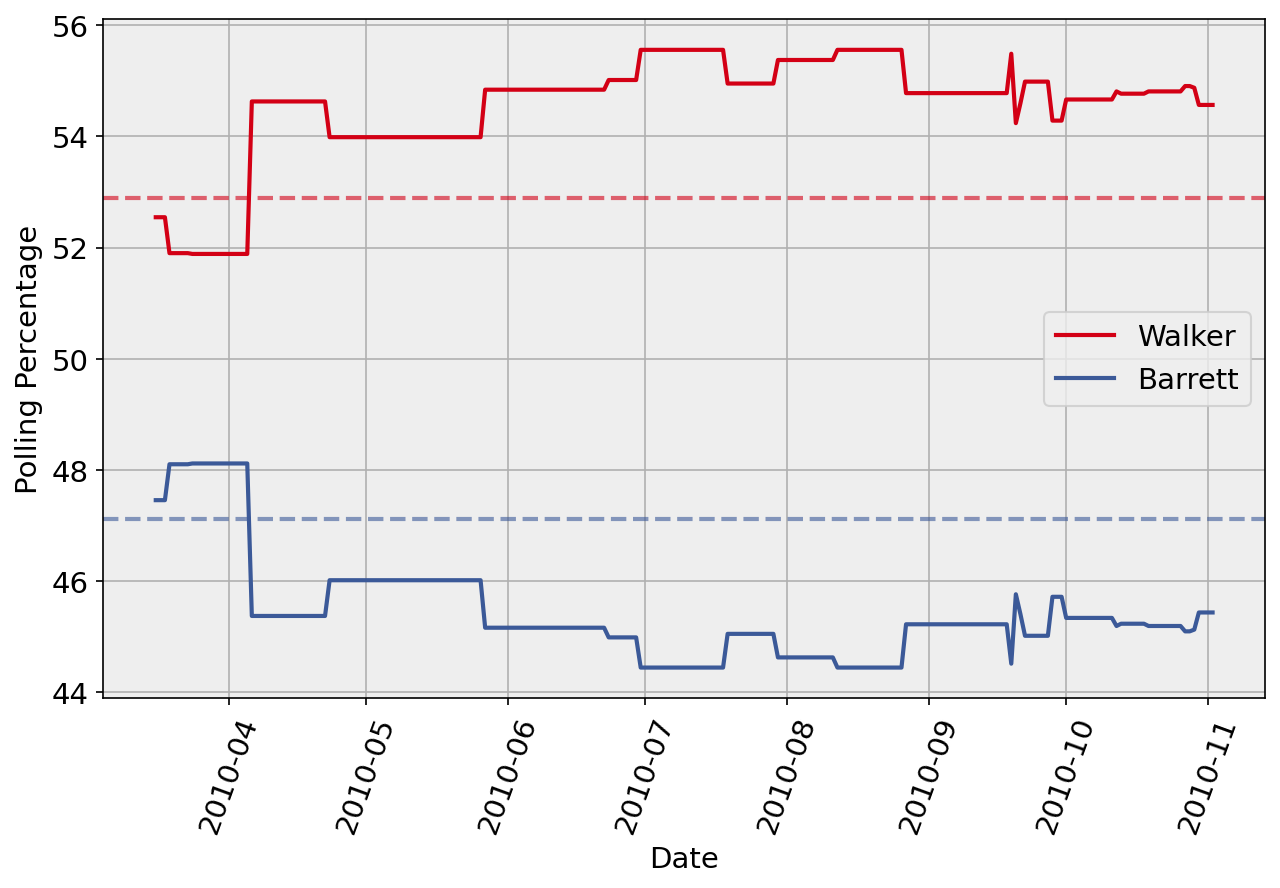

#D30015
Parnell
#3B5998
Berkowitz
   Berkowitz    Parnell 
0   39.403292  60.596708
#D30015
Parnell
#3B5998
Berkowitz


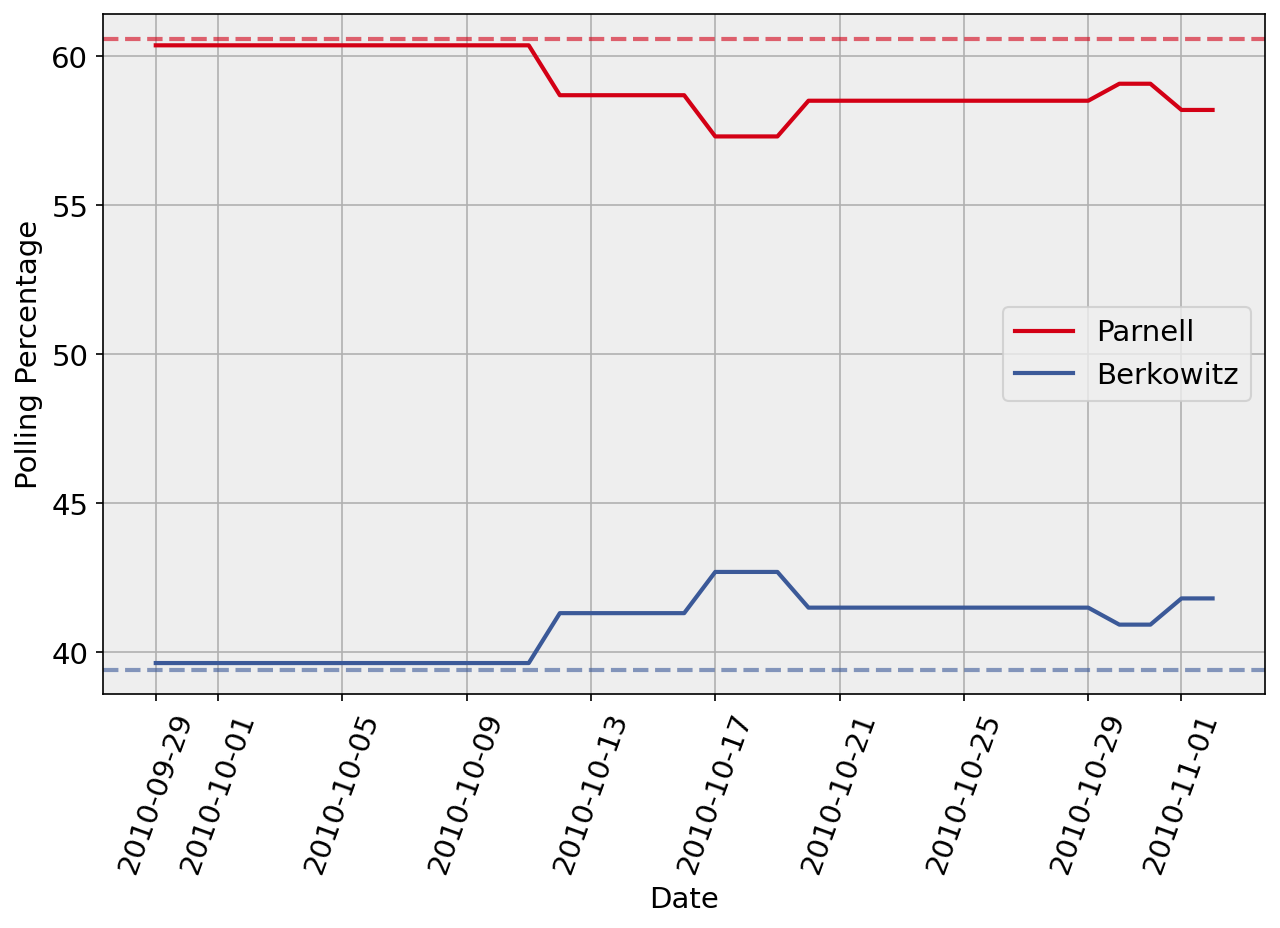

#D30015
Branstad
#3B5998
Culver
   Branstad     Culver 
0  55.036345  44.963655
#D30015
Branstad
#3B5998
Culver


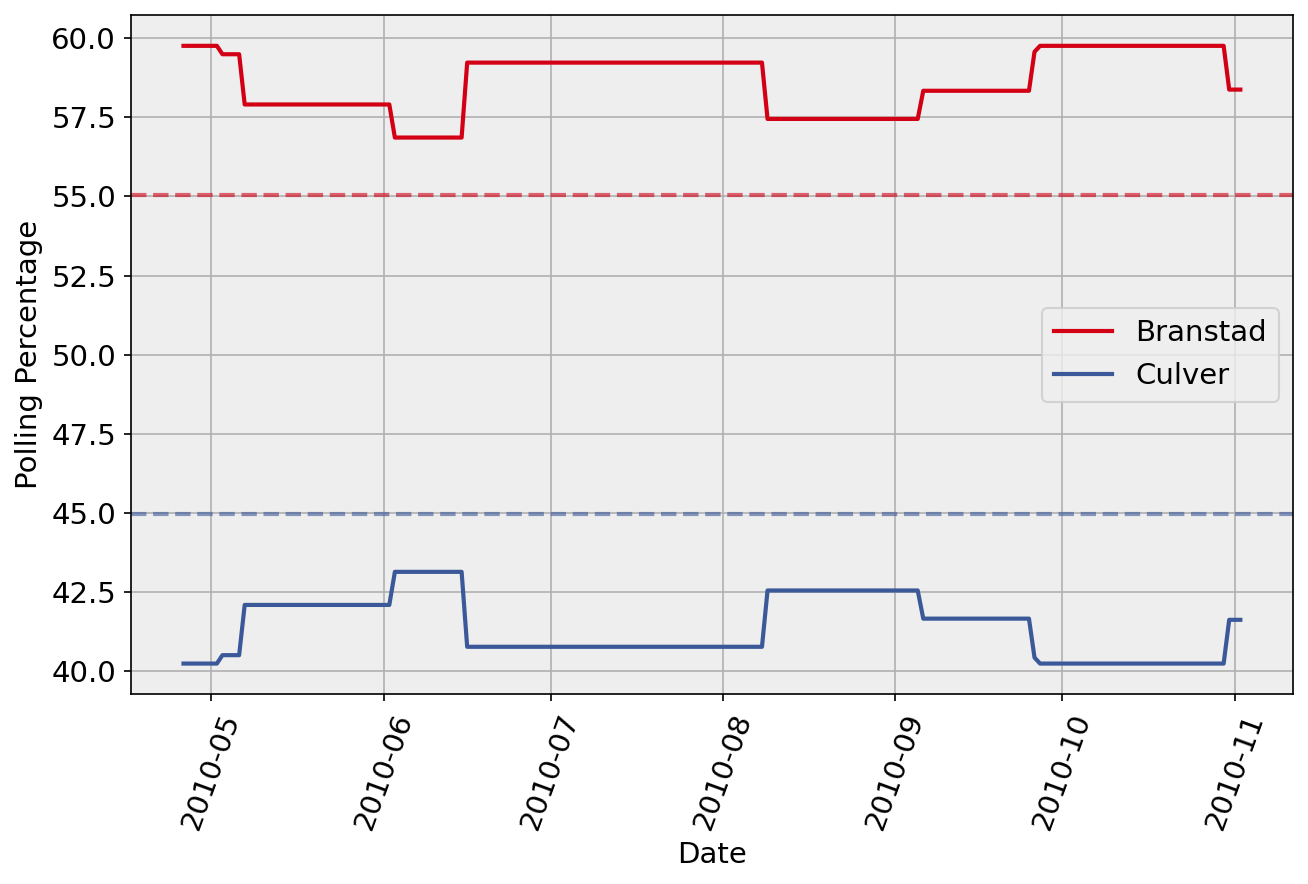

#D30015
LePage
#000000
Cutler
#3B5998
Mitchell
     Cutler     LePage 
0  48.796791  51.203209
#D30015
LePage
#000000
Cutler
#3B5998
Mitchell


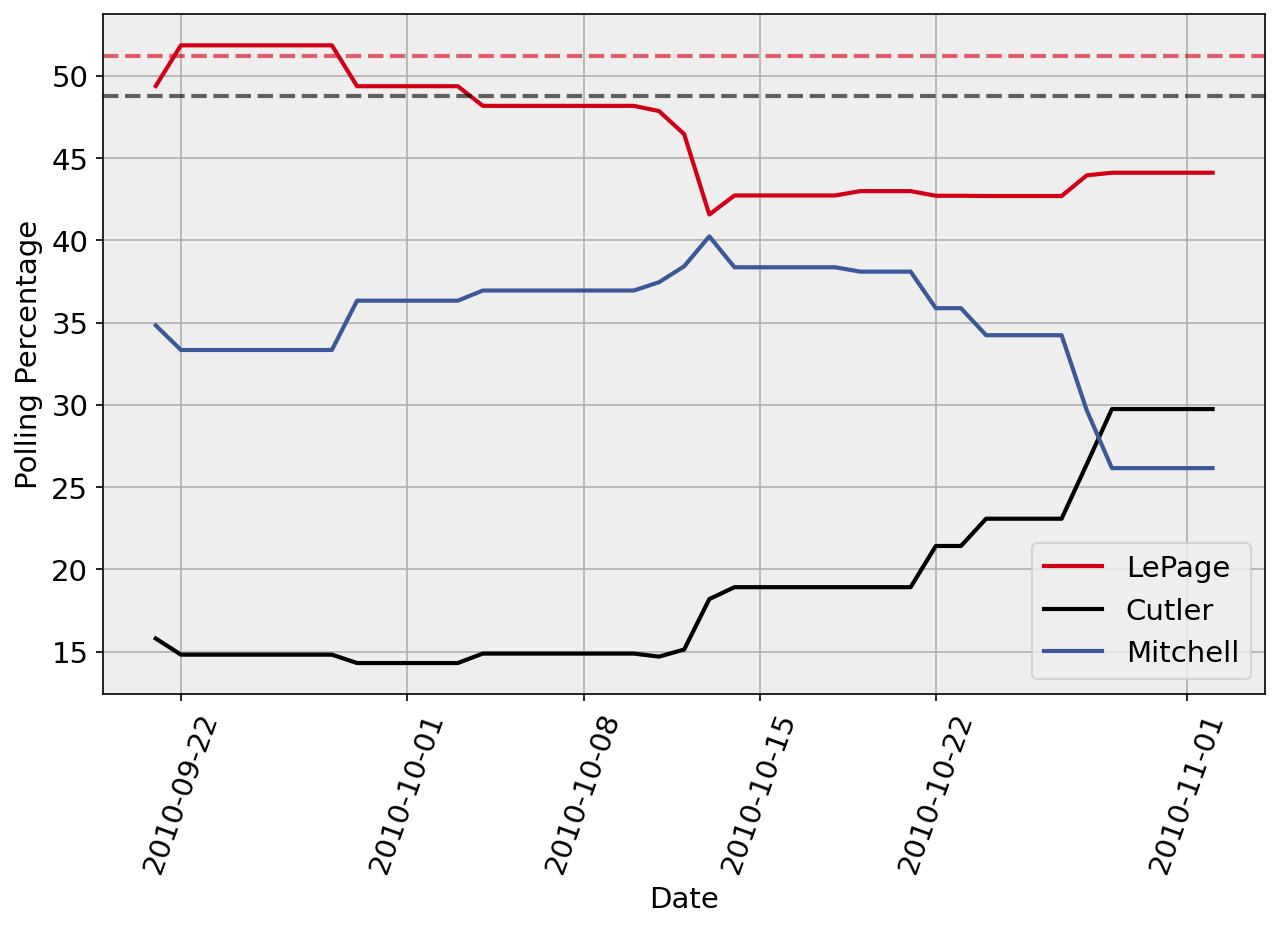

#D30015
Snyder
#3B5998
Bernero
    Bernero     Snyder 
0  40.714286  59.285714
#D30015
Snyder
#3B5998
Bernero


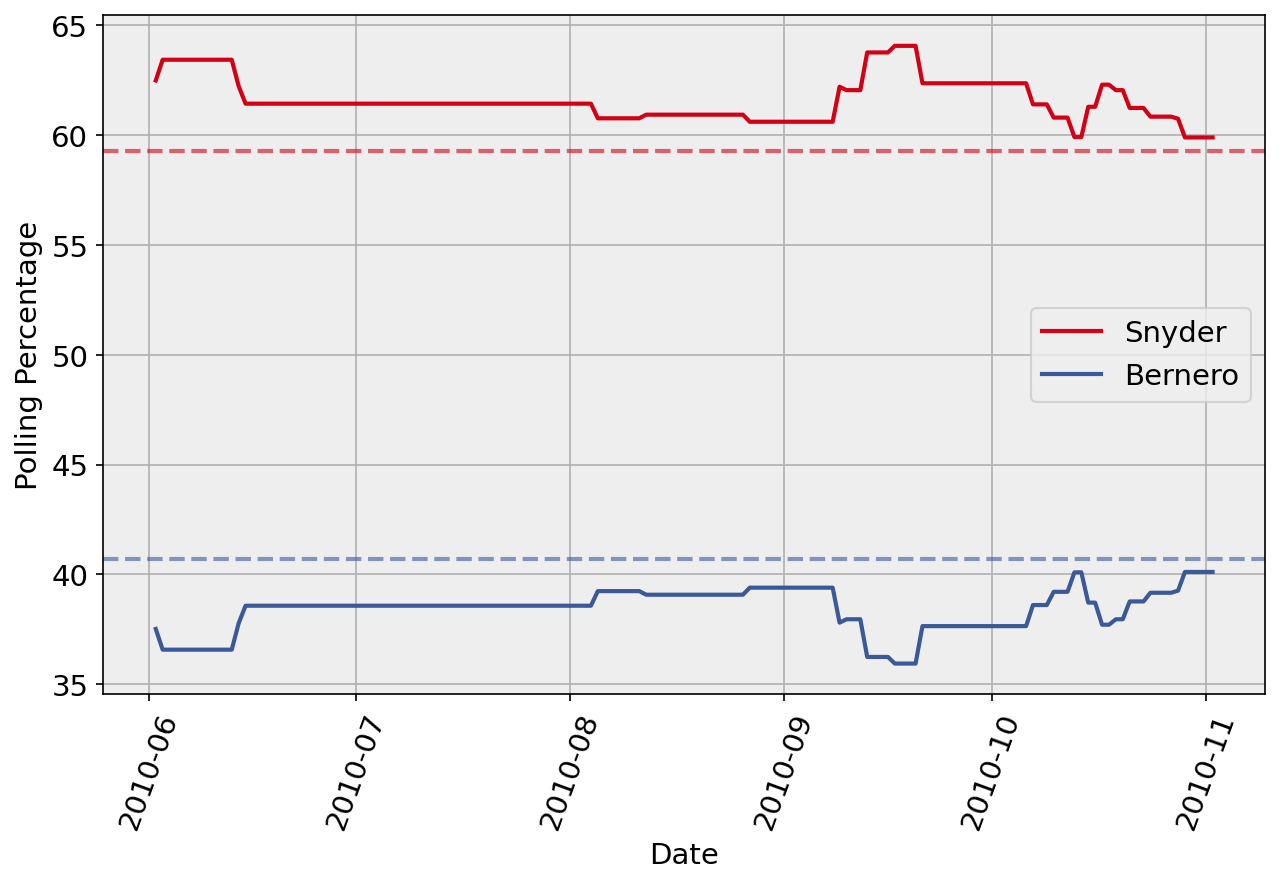

#D30015
Sandoval
#3B5998
Reid
       Reid   Sandoval 
0  43.789474  56.210526
#D30015
Sandoval
#3B5998
Reid


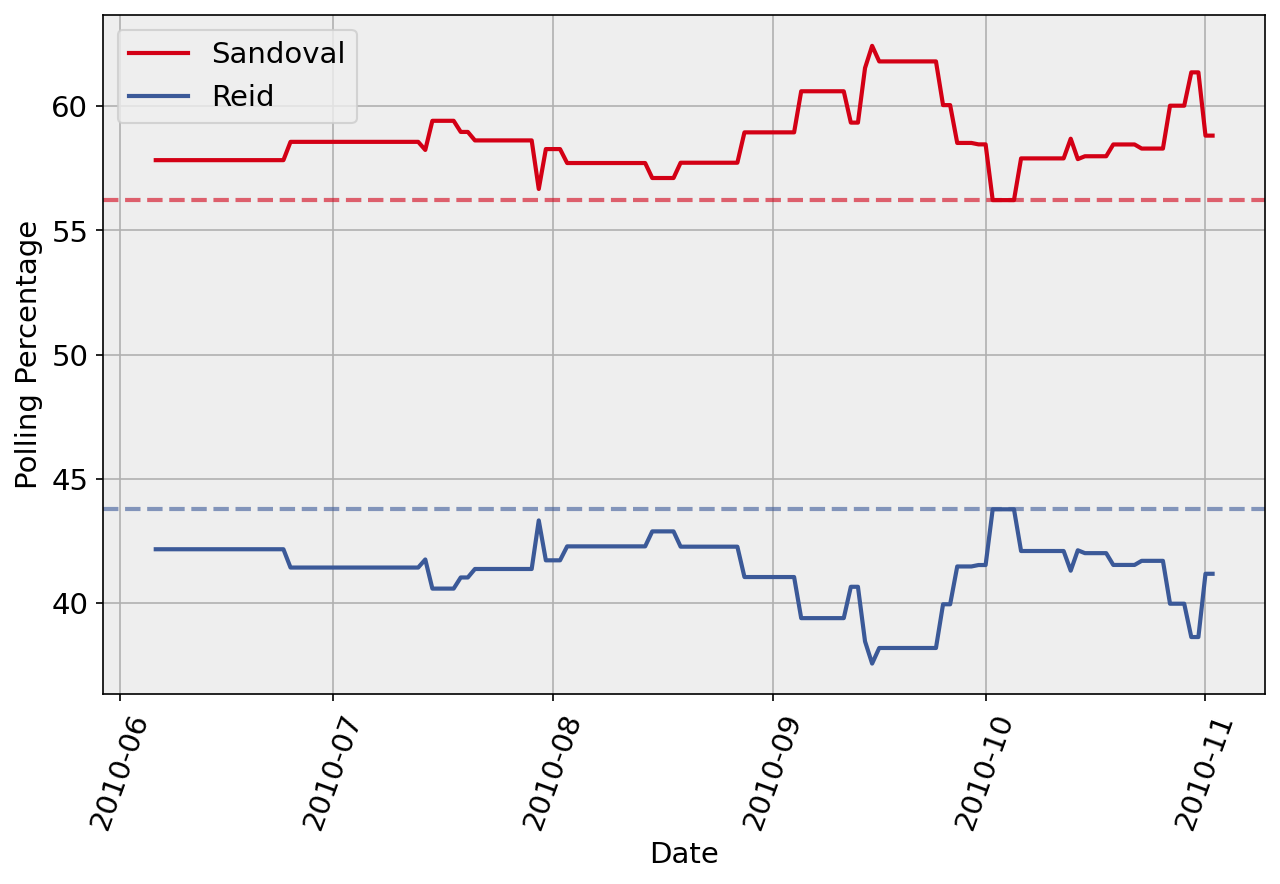

#3B5998
Brown
#D30015
Whitman
      Brown    Whitman 
0  56.012658  43.987342
#3B5998
Brown
#D30015
Whitman


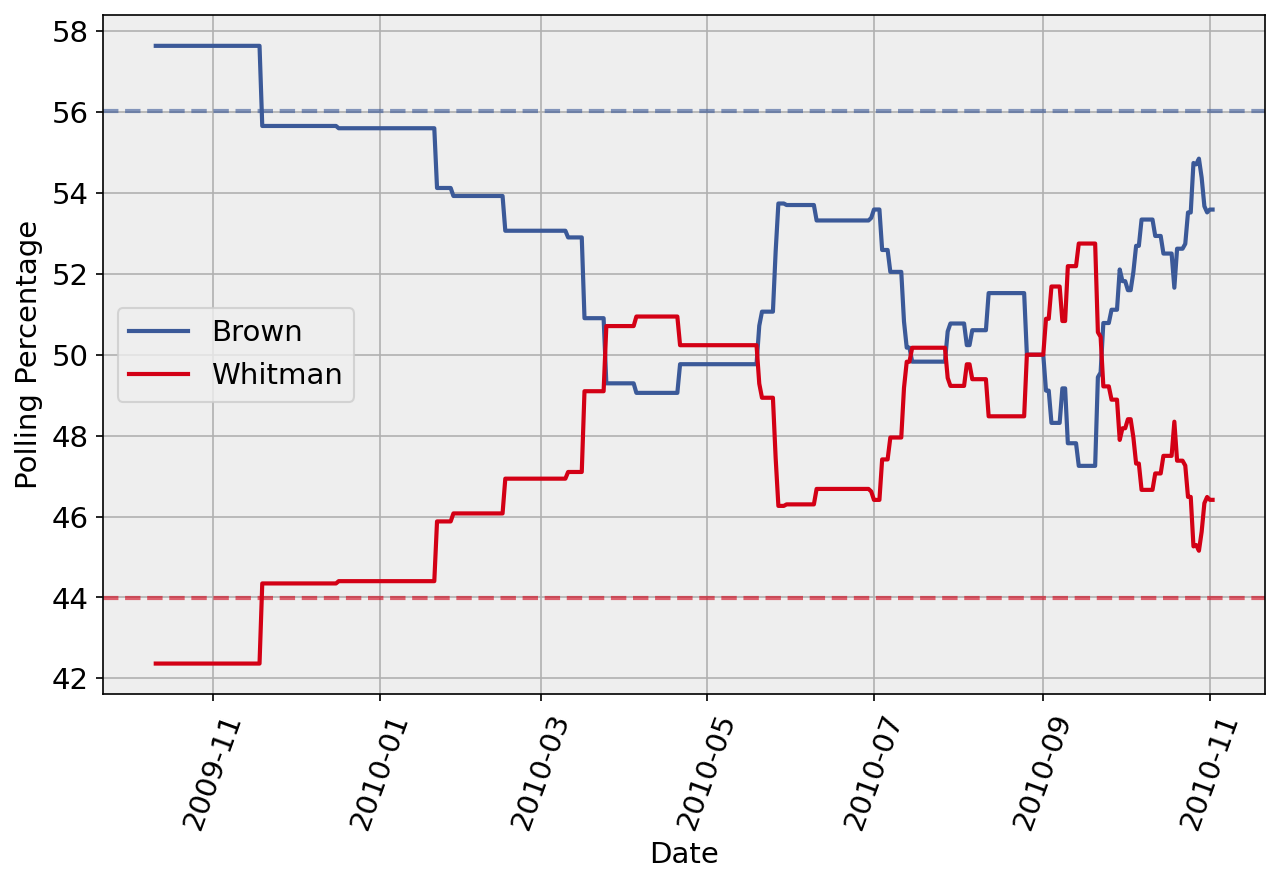

#D30015
Martinez
#3B5998
Denish
   Denish   Martinez 
0     46.4       53.6
#D30015
Martinez
#3B5998
Denish


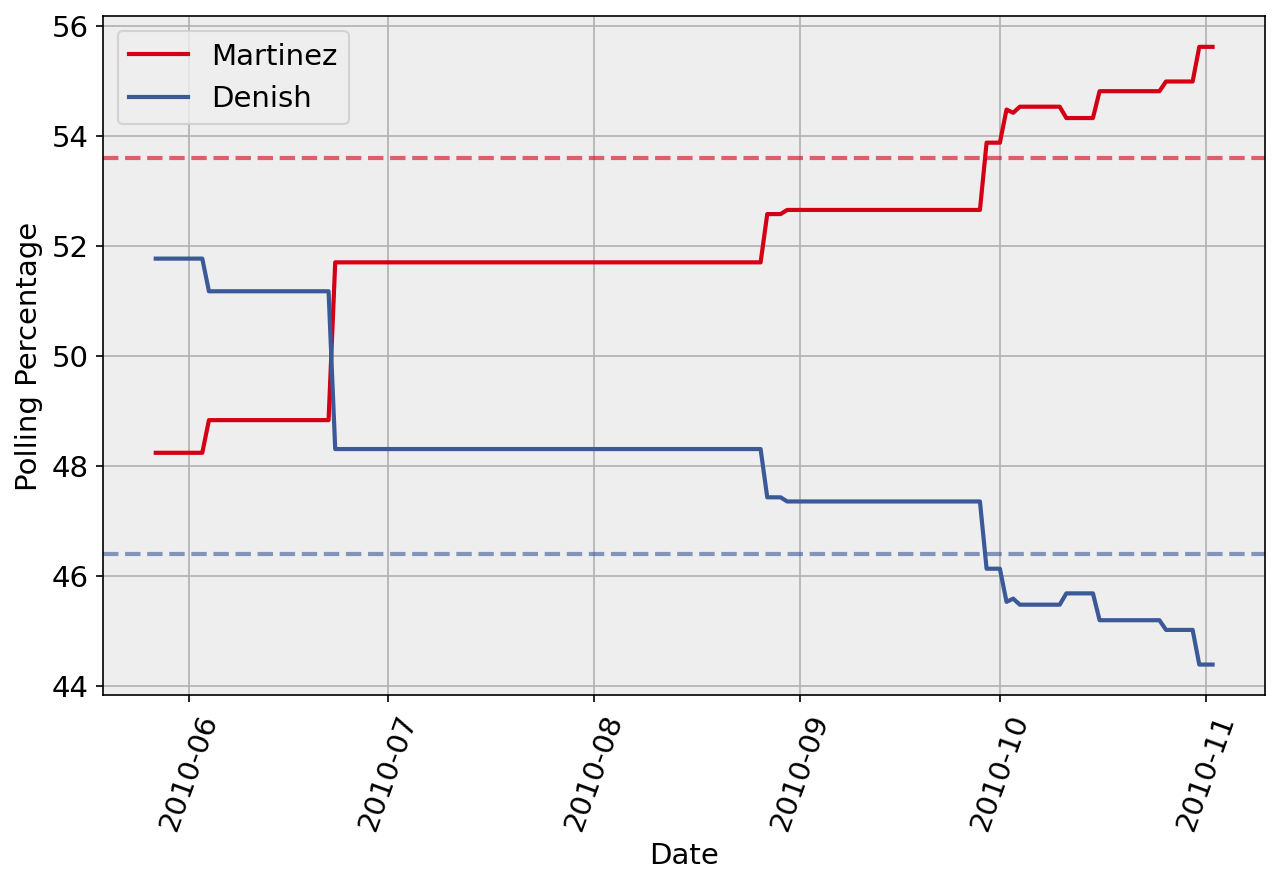

#D30015
Corbett
#3B5998
Onorato
   Corbett   Onorato 
0      54.5      45.5
#D30015
Corbett
#3B5998
Onorato


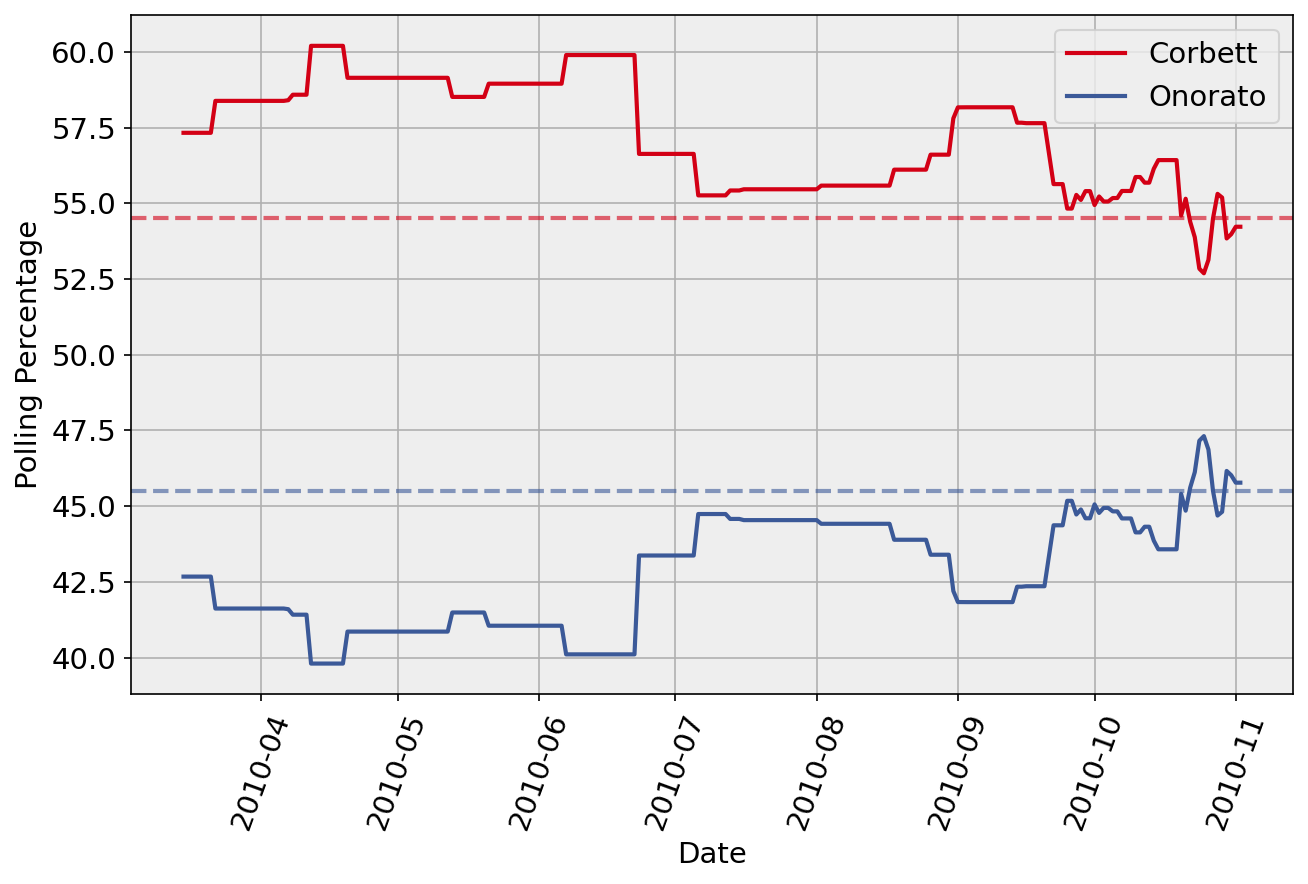

#D30015
Walker
#3B5998
Barrett
    Barrett     Walker 
0  47.118301  52.881699
#D30015
Walker
#3B5998
Barrett


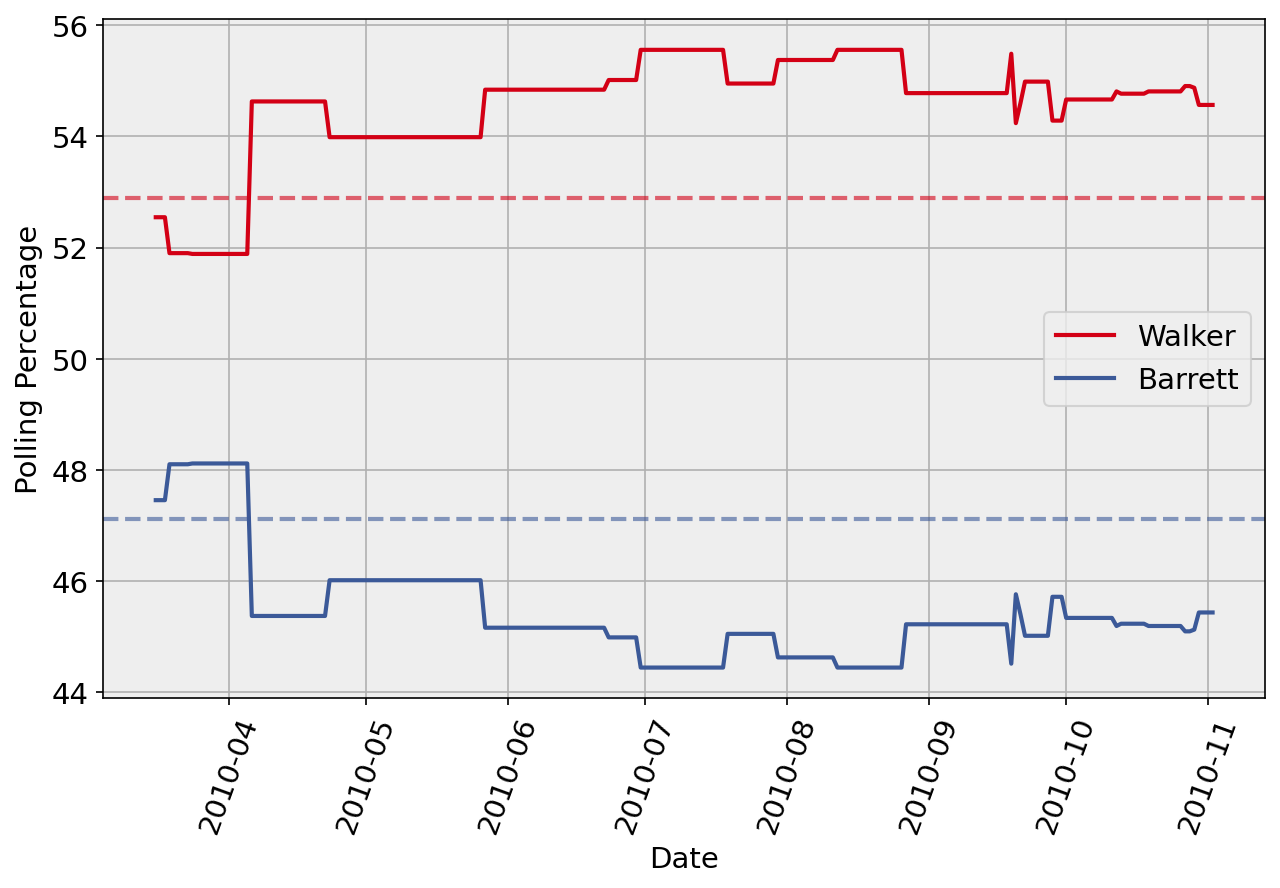

#D30015
Branstad
#3B5998
Culver
   Branstad     Culver 
0  55.036345  44.963655
#D30015
Branstad
#3B5998
Culver


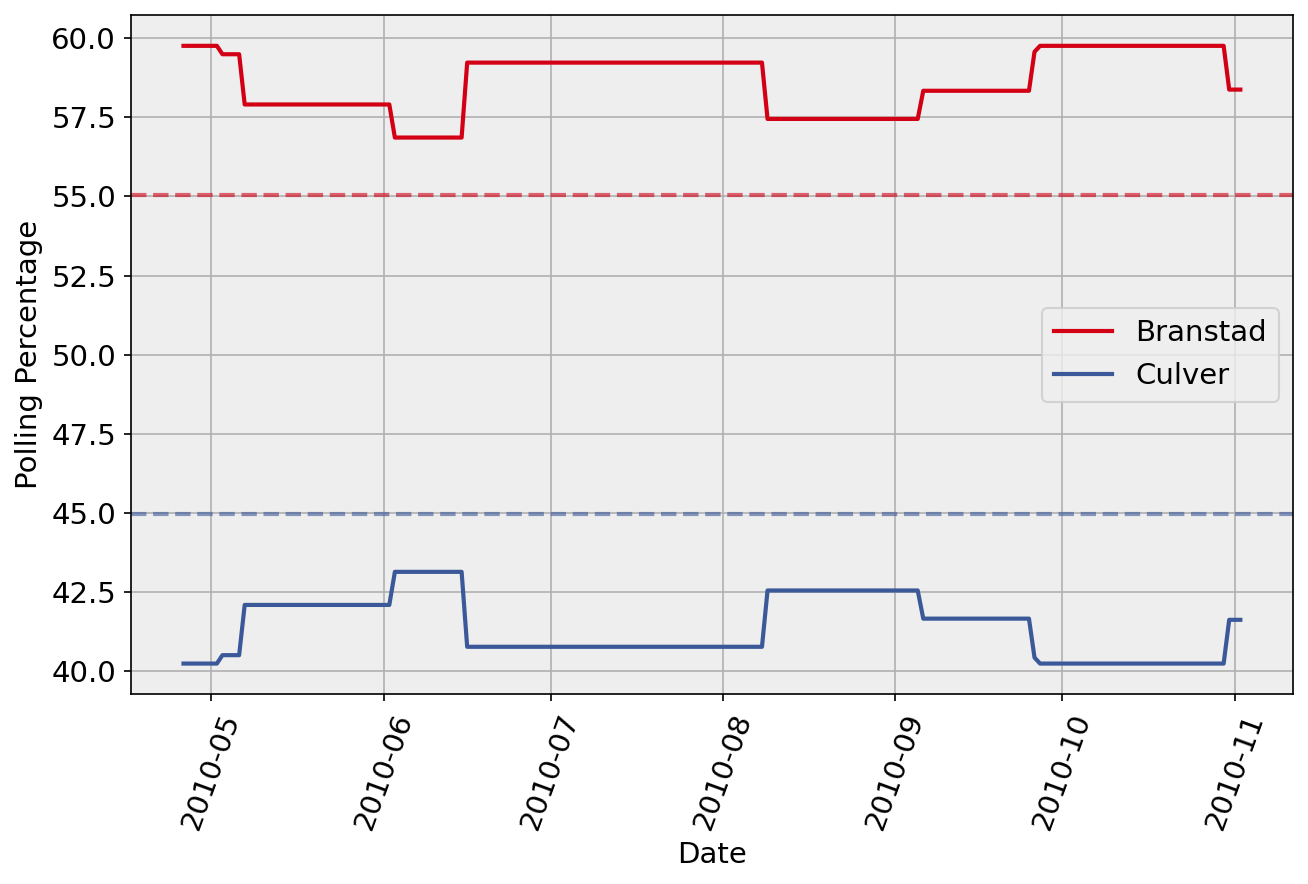

#D30015
LePage
#000000
Cutler
#3B5998
Mitchell
     Cutler     LePage 
0  48.796791  51.203209
#D30015
LePage
#000000
Cutler
#3B5998
Mitchell


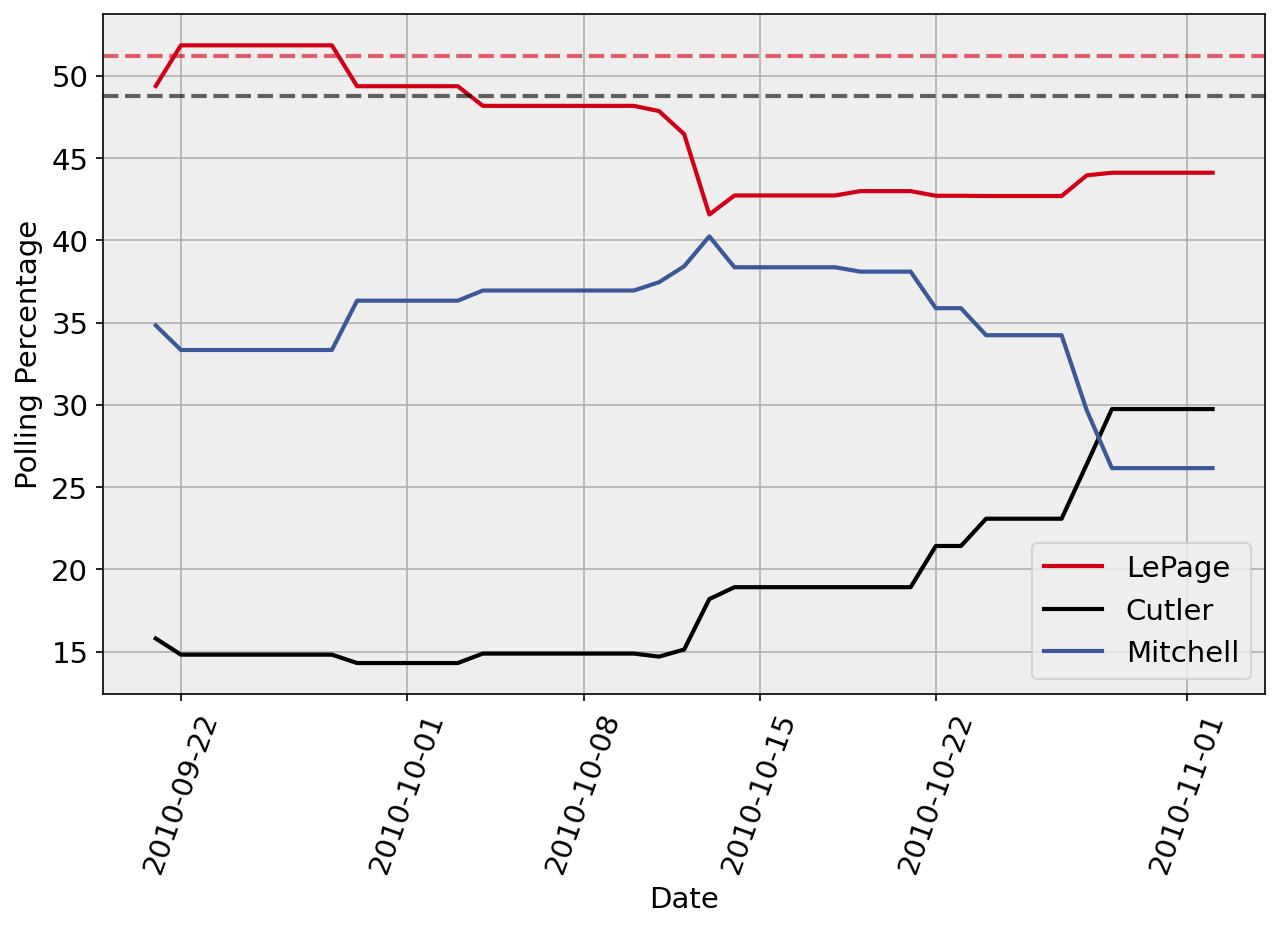

#D30015
Snyder
#3B5998
Bernero
    Bernero     Snyder 
0  40.714286  59.285714
#D30015
Snyder
#3B5998
Bernero


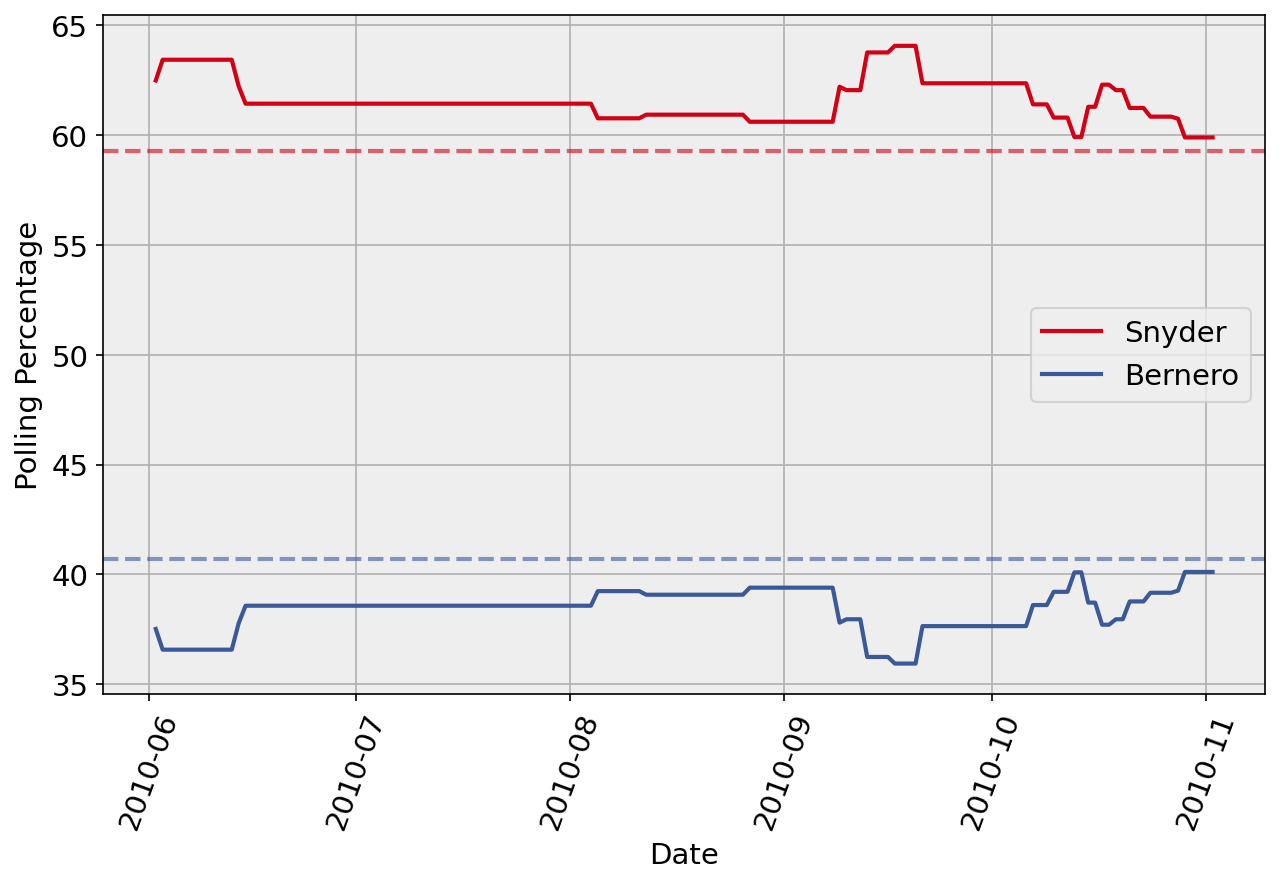

HTTPError: HTTP Error 403: Forbidden

In [174]:
for race in governor_races_list:
    plot_race(race)
    plt.show()



Briefly summarize these graphs -- how accurate is the typical poll a day before the election? How often does a prediction one month before the election mispredict the actual winner?
Your summary here